<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/RubiksCubeAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solving A Rubiks Cube with AI

I think I want this to be a tutorial of my entire process, so I'll be making this notebook like a chronological thought process rather than going back and doing a ton of editing.

This notebook mostly will align with the article, but there are some dead-ends and notes which may not be relvent. This notebook is actually a pretty good example of my thought process when doing modeling.

Requires a high-RAM instance with a T4 GPU

In [ ]:
from google.colab import drive
# Mount Google Drive for saving/loading checkpoints
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Building the Rubiks Cube

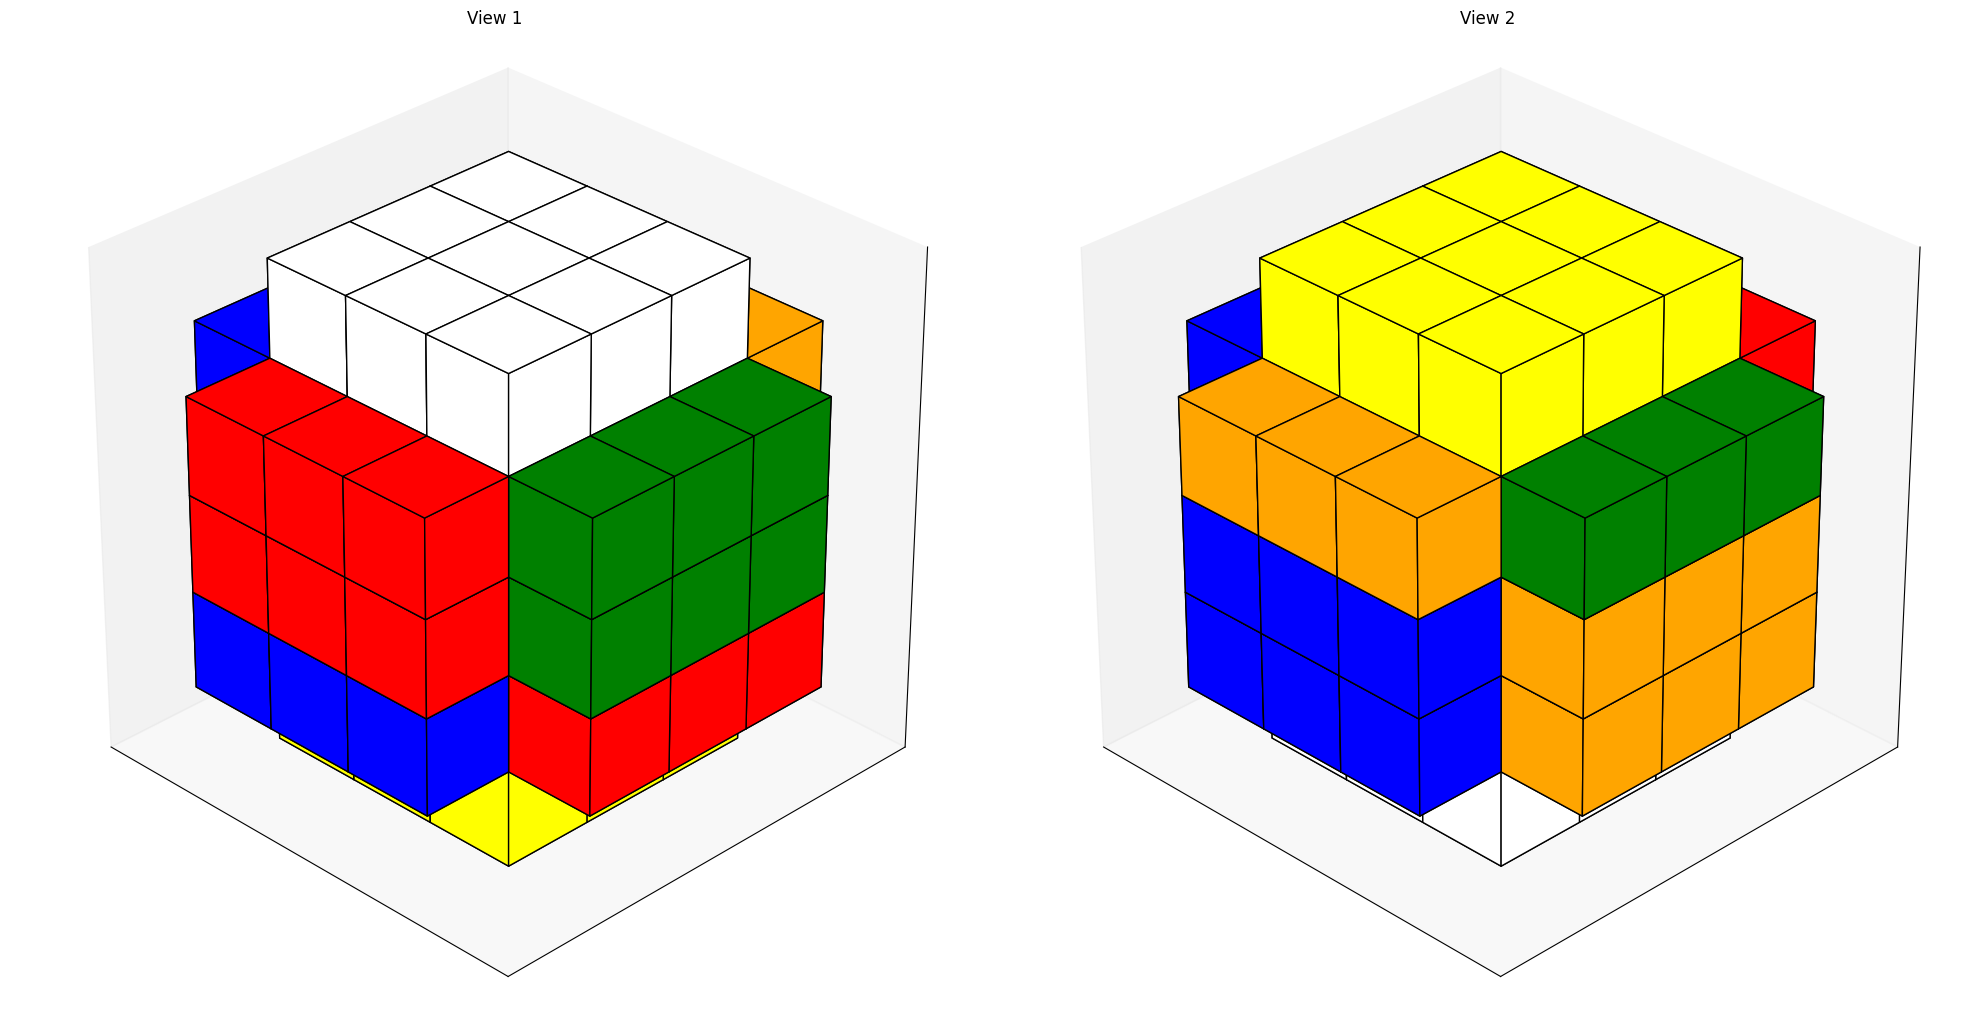

In [ ]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class RubiksCube:
    def __init__(self):
        # Initialize a 3D tensor to represent the Rubik's Cube
        self.cube = np.empty((5, 5, 5), dtype='U10')
        self.cube[:, :, :] = ''

        # Initialize sticker colors
        self.cube[0, 1:-1, 1:-1] = 'w'  # Top (white)
        self.cube[1:-1, 0, 1:-1] = 'g'  # Front (green)
        self.cube[1:-1, 1:-1, 0] = 'r'  # Left (red)
        self.cube[-1, 1:-1, 1:-1] = 'y' # Bottom (yellow)
        self.cube[1:-1, -1, 1:-1] = 'b' # Back (blue)
        self.cube[1:-1, 1:-1, -1] = 'o' # Right (orange)

    def print_cube(self):
        print(self.cube)

    def rotate_face(self, face, reverse=False):
        """
        Rotates a given face of the cube 90 degrees.

        Parameters:
            face (str): One of ['top', 'front', 'left', 'bottom', 'back', 'right']
            reverse (bool): if the rotation should be reversed
        """
        # maps a face to the section of the tensor which needs to be rotated
        rot_map = {
            'top': (slice(0, 2), slice(0, 5), slice(0, 5)),
            'left': (slice(0, 5), slice(0, 2), slice(0, 5)),
            'front': (slice(0, 5), slice(0, 5), slice(0, 2)),
            'bottom': (slice(3, 5), slice(0, 5), slice(0, 5)),
            'right': (slice(0, 5), slice(3, 5), slice(0, 5)),
            'back': (slice(0, 5), slice(0, 5), slice(3, 5))
        }

        # getting all of the stickers that will be rotating
        rotating_slice = self.cube[rot_map[face]]

        # getting the axis of rotation
        axis_of_rotation = np.argmin(rotating_slice.shape)

        # rotating about axis of rotation
        axes_of_non_rotation = [0,1,2]
        axes_of_non_rotation.remove(axis_of_rotation)
        axes_of_non_rotation = tuple(axes_of_non_rotation)
        direction = 1 if reverse else -1
        rotated_slice = np.rot90(rotating_slice, k=direction, axes=axes_of_non_rotation)

        # overwriting cube
        self.cube[rot_map[face]] = rotated_slice

    def _rotate_cube_180(self):
        """
        Rotate the entire cube 180 degrees by flipping and transposing
        this is used for visualization
        """
        # Rotate the cube 180 degrees
        rotated_cube = np.rot90(self.cube, k=2, axes=(0,1))
        rotated_cube = np.rot90(rotated_cube, k=1, axes=(1,2))
        return rotated_cube

    def visualize_opposite_corners(self, return_fig = False):
        """
        Visualize the Rubik's Cube from two truly opposite corners
        """
        # Create a new figure with two subplots
        fig = plt.figure(figsize=(20, 10))

        # Color mapping
        color_map = {
            'w': 'white',
            'g': 'green',
            'r': 'red',
            'y': 'yellow',
            'b': 'blue',
            'o': 'orange'
        }

        # Cubes to visualize: original and 180-degree rotated
        cubes_to_render = [
            {
                'cube_data': self.cube,
                'title': 'View 1'
            },
            {
                'cube_data': self._rotate_cube_180(),
                'title': 'View 2'
            }
        ]

        # Create subplots for each view
        for i, cube_info in enumerate(cubes_to_render, 1):
            ax = fig.add_subplot(1, 2, i, projection='3d')

            ax.view_init(elev=-150, azim=45, vertical_axis='x')

            # Iterate through the cube and plot non-empty stickers
            cube_data = cube_info['cube_data']
            for x in range(cube_data.shape[0]):
                for y in range(cube_data.shape[1]):
                    for z in range(cube_data.shape[2]):
                        # Only plot if there's a color
                        if cube_data[x, y, z] != '':
                            color = color_map.get(cube_data[x, y, z], 'gray')

                            # Define the 8 vertices of the small cube
                            vertices = [
                                [x, y, z], [x+1, y, z],
                                [x+1, y+1, z], [x, y+1, z],
                                [x, y, z+1], [x+1, y, z+1],
                                [x+1, y+1, z+1], [x, y+1, z+1]
                            ]

                            # Define the faces of the cube
                            faces = [
                                [vertices[0], vertices[1], vertices[2], vertices[3]],  # bottom
                                [vertices[4], vertices[5], vertices[6], vertices[7]],  # top
                                [vertices[0], vertices[1], vertices[5], vertices[4]],  # front
                                [vertices[2], vertices[3], vertices[7], vertices[6]],  # back
                                [vertices[1], vertices[2], vertices[6], vertices[5]],  # right
                                [vertices[0], vertices[3], vertices[7], vertices[4]]   # left
                            ]

                            # Plot each face
                            for face in faces:
                                poly = Poly3DCollection([face], alpha=1, edgecolor='black')
                                poly.set_color(color)
                                poly.set_edgecolor('black')
                                ax.add_collection3d(poly)

            # Set axis limits and equal aspect ratio
            ax.set_xlim(0, 5)
            ax.set_ylim(0, 5)
            ax.set_zlim(0, 5)
            ax.set_box_aspect((1, 1, 1))

            # Remove axis labels and ticks
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_zlabel('')
            ax.set_title(cube_info['title'])

        plt.tight_layout()

        #return figure instead of rendering it
        if return_fig:
            return fig

        plt.show()


# Example usage
cube = RubiksCube()

# Rotate a face to show some variation
cube.rotate_face('bottom', reverse=False)

# Visualize from opposite corners
cube.visualize_opposite_corners()

In [ ]:
# Rotate a face to show some variation
cube.rotate_face('right', reverse=False)
cube.rotate_face('top', reverse=False)

cube.cube

array([[['', '', '', '', ''],
        ['', 'b', 'w', 'w', ''],
        ['', 'r', 'w', 'w', ''],
        ['', 'r', 'w', 'w', ''],
        ['', '', '', '', '']],

       [['', 'y', 'r', 'r', ''],
        ['o', '', '', '', 'g'],
        ['b', '', '', '', 'g'],
        ['b', '', '', '', 'g'],
        ['', 'w', 'o', 'o', '']],

       [['', 'g', 'g', 'g', ''],
        ['r', '', '', '', 'o'],
        ['r', '', '', '', 'o'],
        ['y', '', '', '', 'w'],
        ['', 'o', 'b', 'b', '']],

       [['', 'r', 'r', 'r', ''],
        ['b', '', '', '', 'g'],
        ['b', '', '', '', 'g'],
        ['y', '', '', '', 'w'],
        ['', 'o', 'b', 'b', '']],

       [['', '', '', '', ''],
        ['', 'y', 'y', 'y', ''],
        ['', 'y', 'y', 'y', ''],
        ['', 'g', 'o', 'o', ''],
        ['', '', '', '', '']]], dtype='<U10')

[('left', True), ('left', False), ('left', True), ('left', False), ('right', True), ('bottom', False), ('front', False), ('back', False), ('front', False), ('back', False), ('back', False), ('left', True), ('right', False), ('front', True), ('right', False), ('left', True), ('front', True), ('back', False), ('front', True), ('back', True)]


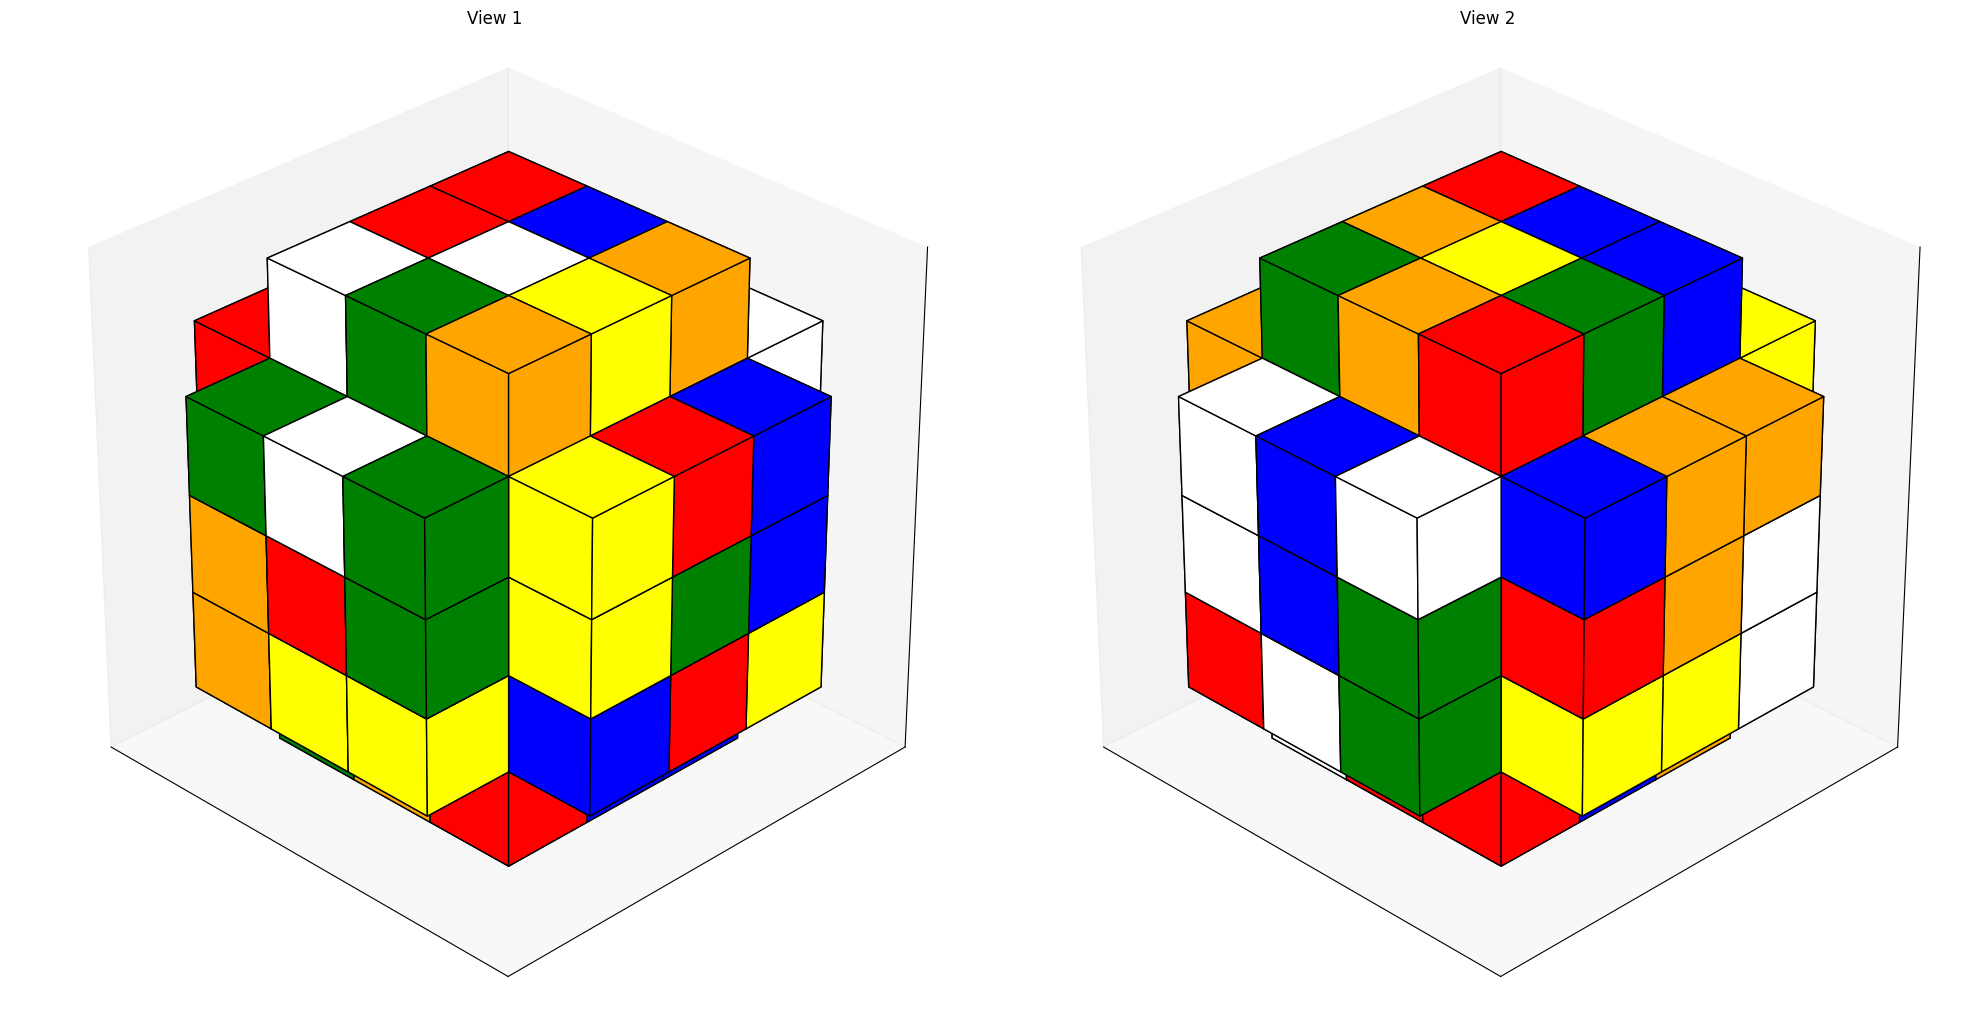

In [ ]:

from itertools import product
import random

#Defining Possible Moves
faces = ['top', 'left', 'front', 'bottom', 'right', 'back']
possible_moves = tuple(product(faces, [False, True]))


def scramble(cube, n=20):
    moves = []
    for _ in range(n):
        #selecting a random move
        selected_move = random.choice(possible_moves)
        moves.append(selected_move)

        # Rotate a face to show some variation
        cube.rotate_face(selected_move[0], reverse=selected_move[1])
    return moves

#creating a cube
cube = RubiksCube()

#shuffling
moves = scramble(cube)
print(moves)

# Visualize from opposite corners
cube.visualize_opposite_corners()

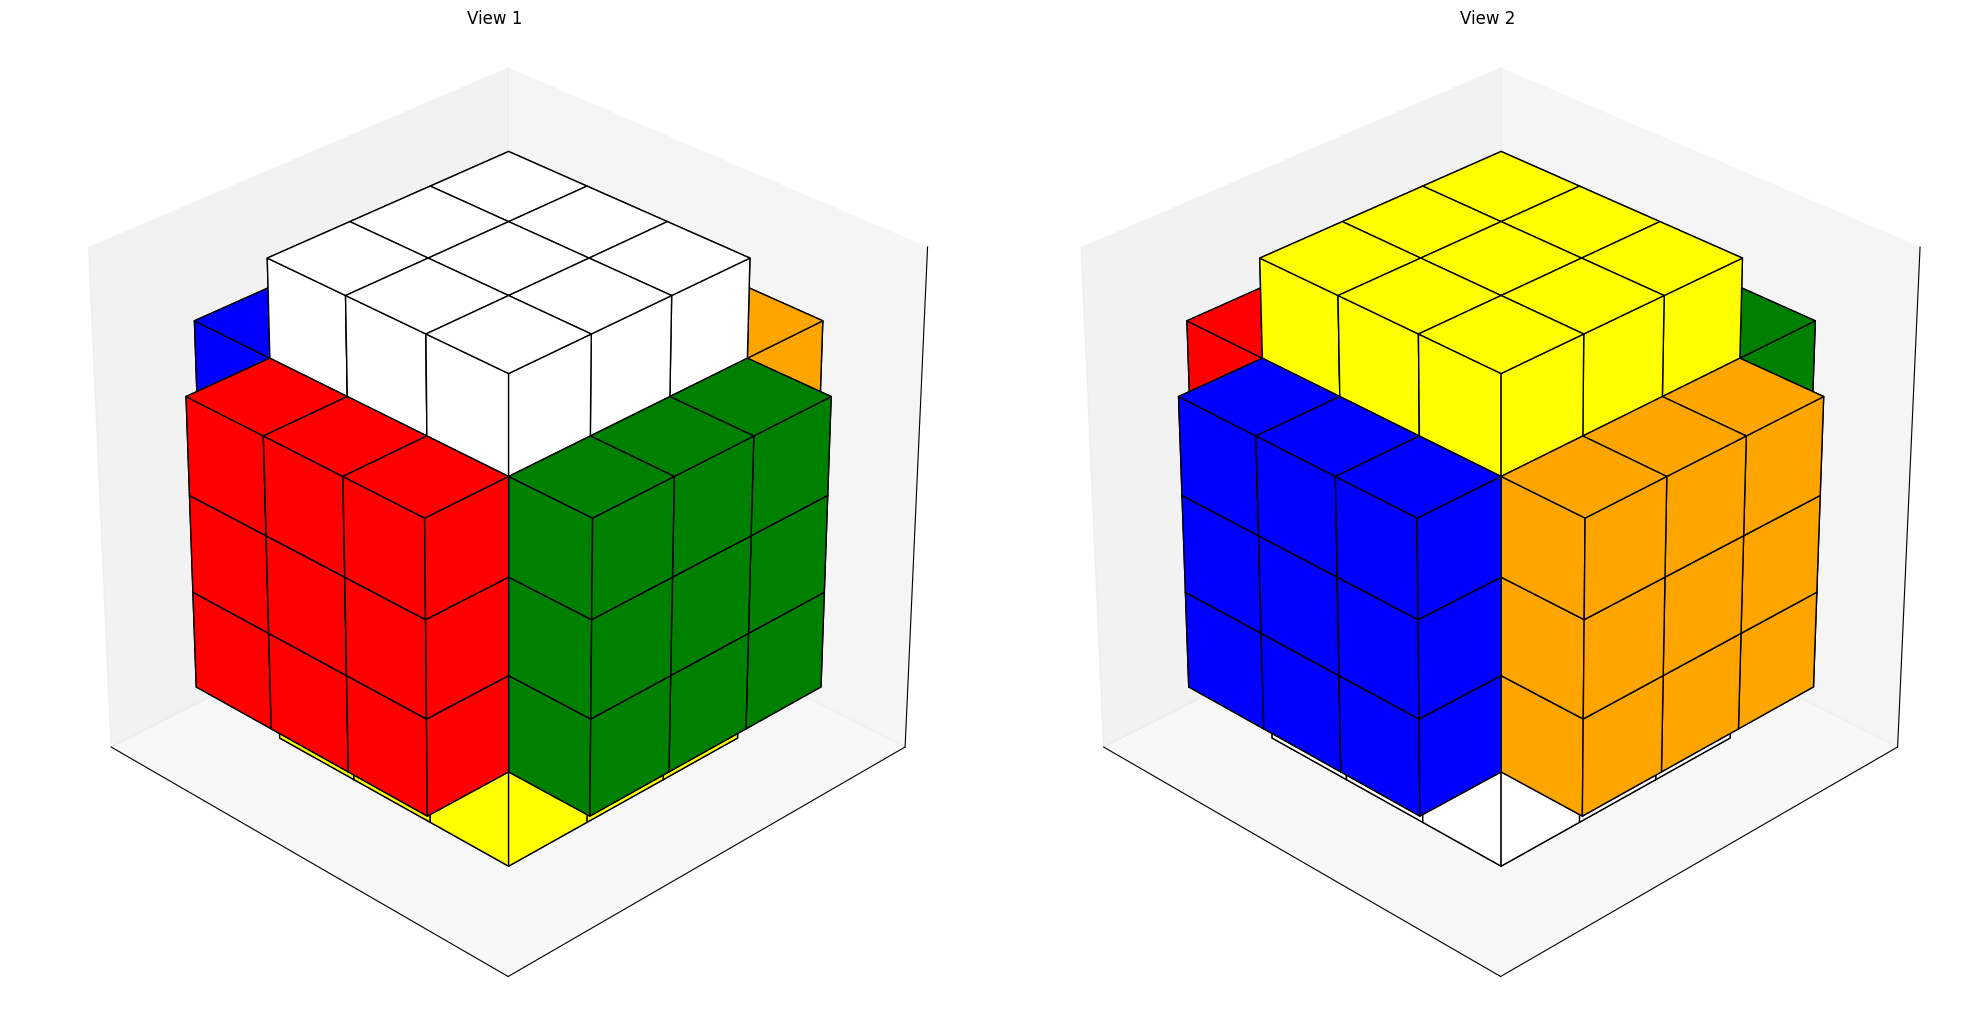

In [ ]:
#unscrambling
moves.reverse()

for i in range(20):
    #selecting a random move
    selected_move = moves[i]

    # Rotate a face to show some variation
    cube.rotate_face(selected_move[0], reverse=not selected_move[1])

# Visualize from opposite corners
cube.visualize_opposite_corners()

# Constructing a Dataset
This really consists of two things:
1. mapping the cube representation into a tensor which an AI model
can readily understand
2. mapping moves into a representation an AI model can output, and also a way to map output to moves.

Then I can just randomly scramble the cube a bunch of times and construct a dataset of solutions.

## Creating Input and Output Representation
I'm extracting every sticker on the cube and getting an X,Y, and Z value. The input to the model will have a vocabulary of stickers, and positional embeddings for the x, y, and z axis.

In [ ]:
sticker_map = {'w':0, 'g':1, 'r':2, 'o':3, 'b':4, 'y':5}

def tokenize(arr):
    """Turns the rubiks cube into tokens to be the input of the model
    """
    token_lookups = []
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            for k in range(arr.shape[2]):
                if arr[i, j, k] != '':
                    value = sticker_map[arr[i, j, k]]
                    token_lookups.append((value, i, j, k))

    return token_lookups

tokenize(cube.cube)

[(0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (1, 1, 0, 1),
 (1, 1, 0, 2),
 (1, 1, 0, 3),
 (2, 1, 1, 0),
 (3, 1, 1, 4),
 (2, 1, 2, 0),
 (3, 1, 2, 4),
 (2, 1, 3, 0),
 (3, 1, 3, 4),
 (4, 1, 4, 1),
 (4, 1, 4, 2),
 (4, 1, 4, 3),
 (1, 2, 0, 1),
 (1, 2, 0, 2),
 (1, 2, 0, 3),
 (2, 2, 1, 0),
 (3, 2, 1, 4),
 (2, 2, 2, 0),
 (3, 2, 2, 4),
 (2, 2, 3, 0),
 (3, 2, 3, 4),
 (4, 2, 4, 1),
 (4, 2, 4, 2),
 (4, 2, 4, 3),
 (1, 3, 0, 1),
 (1, 3, 0, 2),
 (1, 3, 0, 3),
 (2, 3, 1, 0),
 (3, 3, 1, 4),
 (2, 3, 2, 0),
 (3, 3, 2, 4),
 (2, 3, 3, 0),
 (3, 3, 3, 4),
 (4, 3, 4, 1),
 (4, 3, 4, 2),
 (4, 3, 4, 3),
 (5, 4, 1, 1),
 (5, 4, 1, 2),
 (5, 4, 1, 3),
 (5, 4, 2, 1),
 (5, 4, 2, 2),
 (5, 4, 2, 3),
 (5, 4, 3, 1),
 (5, 4, 3, 2),
 (5, 4, 3, 3)]

In [ ]:
def move_to_output_index(move):
    return possible_moves.index(move)

def output_index_to_move(i):
    return possible_moves[i]


move = ('top', True)
i = move_to_output_index(move)
move_lookup = output_index_to_move(i)

print(move)
print(move_lookup)

('top', True)
('top', True)


## Constructing Dataset
The dataset will consist of
- X = The scrambled state of the rubiks cube
- y = the sequence of move indexes to solve it

The y value will requires some utility tokens.
- [BOS]: beginning of sequence
- [EOS]: end of sequence
- [PAD]: padding to make all sequences a consistent length

Which will be at indexes 0,1, and 2 respectively. So, the move indexes need to be offset by 3.

The move sequence will simply be the oposite of what was done to scramble the
rubiks cube.

In [ ]:
# X = []
# y = []
# num_samples = 1_000

# for _ in range(num_samples):
#     num_moves = random.randint(1, 20)

#     #initializing a cube and scrambling it
#     cube = RubiksCube()
#     moves = scramble(cube, n=num_moves)

#     #reversing moves, which is the solution
#     moves.reverse()
#     moves = [(m[0], not m[1]) for m in moves]

#     #turning into modeling data
#     X.append(tokenize(cube.cube))
#     y.append([0]+[move_to_output_index(m)+3 for m in moves]+[1])

#     #padding with -1s so the sequence length is always of length 20 (plus start and end pads, so 22)
#     y[-1].extend([2] * (22 - len(y[-1])))

That takes a lot of time to calculate for large datasets, so parallelizing:

In [ ]:
import random
from multiprocessing import Pool, cpu_count
from functools import partial

def generate_sample(max_scramble, _):
    """
    Generates a single sample (X, y) for the Rubik's Cube task.
    """
    num_moves = random.randint(1, max_scramble)

    # Initializing a cube and scrambling it
    cube = RubiksCube()
    moves = scramble(cube, n=num_moves)

    # Reversing moves, which is the solution
    moves.reverse()
    moves = [(m[0], not m[1]) for m in moves]

    # Turning into modeling data
    x = tokenize(cube.cube)
    y = [0] + [move_to_output_index(m) + 3 for m in moves] + [1]

    # Padding with -1s so the sequence length is always 22
    y.extend([2] * (22 - len(y)))

    return x, y

def parallel_generate_samples(num_samples, max_scramble, num_workers=None):
    """
    Parallelizes the generation of Rubik's Cube samples.
    """
    num_workers = num_workers or cpu_count()

    # Use functools.partial to "lock in" the max_scramble parameter
    generate_sample_partial = partial(generate_sample, max_scramble)

    with Pool(processes=num_workers) as pool:
        results = pool.map(generate_sample_partial, range(num_samples))

    # Unpack results into X and y
    X, y = zip(*results)
    return list(X), list(y)

# num_samples = 2_000_000
num_samples = 10
max_scramble = 20

# Generate data in parallel
X, y = parallel_generate_samples(num_samples, max_scramble)

In [ ]:
y

[[0, 13, 9, 9, 7, 3, 6, 3, 3, 10, 11, 9, 13, 8, 1, 2, 2, 2, 2, 2, 2, 2],
 [0, 9, 8, 8, 13, 11, 12, 5, 6, 8, 4, 8, 10, 10, 4, 4, 1, 2, 2, 2, 2, 2],
 [0, 3, 14, 13, 8, 12, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [0, 14, 13, 4, 13, 5, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [0, 12, 8, 11, 14, 10, 9, 4, 5, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [0, 14, 6, 7, 11, 8, 8, 6, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [0, 8, 5, 9, 3, 5, 5, 10, 10, 12, 11, 10, 5, 14, 8, 10, 14, 7, 1, 2, 2, 2],
 [0, 7, 8, 4, 5, 6, 5, 4, 7, 12, 4, 9, 13, 7, 11, 7, 5, 9, 8, 11, 1, 2],
 [0, 9, 10, 4, 4, 14, 14, 4, 12, 11, 4, 10, 8, 9, 1, 2, 2, 2, 2, 2, 2, 2],
 [0, 8, 4, 13, 13, 6, 13, 5, 8, 9, 7, 12, 14, 12, 12, 13, 4, 3, 1, 2, 2, 2]]

Ok this is pretty much the representation I'll need, but it's not exactly the representation I need. I really need:
- X as a numpy array
- y as a numpy array


In [ ]:
#converting X to a numpy array, instead of a list of tuples
X = np.array(X)
y = np.array(y)

In [ ]:
X.shape

(2000000, 54, 4)

In [ ]:
y.shape

(2000000, 22)

# Creating Data Loader
We're going to train the model in batches. This loads the batches

In [ ]:
import torch

#turning numpy arrays into tensors
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X: Input data (NumPy array, shape: [num_samples, seq_length, num_features])
            y: Target data (NumPy array, shape: [num_samples, seq_length, target_features])
        """
        self.X = X  # Convert X to PyTorch tensor
        self.y = y  # Convert y to PyTorch tensor

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetches a single sample by index.
        Args:
            idx: Index of the sample to fetch
        Returns:
            Tuple of (X[idx], y[idx])
        """
        return self.X[idx], self.y[idx]

# Create the dataset
dataset = CustomDataset(X, y)

# Create the DataLoader
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example usage
for batch_X, batch_y in data_loader:
    print(f"Batch X shape: {batch_X.shape}")
    print(f"Batch y shape: {batch_y.shape}")
    break

Batch X shape: torch.Size([64, 54, 4])
Batch y shape: torch.Size([64, 22])


# Constructing the Model
I'll be constructing an encoder-decoder style transformer, where the encoder accepts the scrambled rubiks cube, and the decoder autoregressively generates steps to solve the cube.

## Encoder Embedding
This takes the rubiks cube representation and turns it into a vector based on looking up learnable parameters

In [ ]:
import torch
import torch.nn as nn

class EncoderEmbedding(nn.Module):
    def __init__(self, vocab_size=6, pos_i_size=5, pos_j_size=5, pos_k_size=5, embedding_dim=128):
        super(EncoderEmbedding, self).__init__()

        # Learnable embeddings for each component
        self.vocab_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_i_embedding = nn.Embedding(pos_i_size, embedding_dim)
        self.pos_j_embedding = nn.Embedding(pos_j_size, embedding_dim)
        self.pos_k_embedding = nn.Embedding(pos_k_size, embedding_dim)

    def forward(self, X):
        """
        Args:
            X (torch.Tensor): Input tensor of shape (batch_size, seq_len, 4)
                where X[..., 0] = vocab indices (0-5)
                      X[..., 1] = position i (0-4)
                      X[..., 2] = position j (0-4)
                      X[..., 3] = position k (0-4)
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, embedding_dim)
        """
        # Split the input into components
        vocab_idx = X[..., 0]
        pos_i_idx = X[..., 1]
        pos_j_idx = X[..., 2]
        pos_k_idx = X[..., 3]

        # Look up embeddings
        vocab_embed = self.vocab_embedding(vocab_idx)
        pos_i_embed = self.pos_i_embedding(pos_i_idx)
        pos_j_embed = self.pos_j_embedding(pos_j_idx)
        pos_k_embed = self.pos_k_embedding(pos_k_idx)

        # Sum the embeddings
        final_embedding = vocab_embed + pos_i_embed + pos_j_embed + pos_k_embed
        return final_embedding


embedding_dim = 128

# Initialize the input embedding module
encoder_embedding = EncoderEmbedding(embedding_dim=embedding_dim)

# Get the final embeddings
embedded_encoder_input = encoder_embedding(X[:10])
print("Input shape:", X[:10].shape)
print("Output shape:", embedded_encoder_input.shape)

Input shape: torch.Size([10, 54, 4])
Output shape: torch.Size([10, 54, 128])


# Encoder

In [ ]:
import torch
import torch.nn as nn

# Define the Transformer Encoder with batch_first=True
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoder, self).__init__()

        # Define a single transformer encoder layer with batch_first=True
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True  # Important to enable batch_first
        )

        # Stack multiple encoder layers
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """
        Args:
            src (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model).
            src_mask (torch.Tensor, optional): Mask for attention weights (seq_len, seq_len).
            src_key_padding_mask (torch.Tensor, optional): Mask to ignore specific positions (batch_size, seq_len).
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, d_model).
        """
        return self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)

# Example usage
num_heads = 8
num_layers = 6
d_ff = 2048
dropout = 0.1

# Initialize the transformer encoder
encoder = TransformerEncoder(num_layers=num_layers, d_model=embedding_dim, num_heads=num_heads, d_ff=d_ff, dropout=dropout)

# Forward pass
encoder_output = encoder(embedded_encoder_input)

print("Encoder output shape:", encoder_output.shape)  # Should be (seq_len, batch_size, d_model)

Encoder output shape: torch.Size([10, 54, 128])


# Decoder Embedding
This is very similar to the encoder embedding, accept there's only one positional dimension and it has a length of 22 (seq length of 2 plus [SOS] and [EOS]) and the vocabulary is 15 (12 moves, [SOS], [EOS], and [PAD])

In [ ]:
class DecoderEmbedding(nn.Module):
    def __init__(self, vocab_size=15, pos_size=22, embedding_dim=128):
        super(DecoderEmbedding, self).__init__()

        # Learnable embeddings for each component
        self.vocab_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_embedding = nn.Embedding(pos_size, embedding_dim)

    def forward(self, X):
        """
        Args:
            X (torch.Tensor): Input tensor of shape (batch_size, seq_len), where each element
                              corresponds to a token index.

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, embedding_dim)
        """
        # Token embeddings (based on vocab indices)
        vocab_embed = self.vocab_embedding(X)

        # Generate position indices based on input shape
        batch_size, seq_len = X.shape
        position_indices = torch.arange(seq_len, device=X.device).unsqueeze(0).expand(batch_size, -1)

        # Position embeddings
        pos_embedding = self.pos_embedding(position_indices)

        # Sum the embeddings
        final_embedding = vocab_embed + pos_embedding
        return final_embedding


embedding_dim = 128

# Initialize the input embedding module
decoder_embedding = DecoderEmbedding(embedding_dim=embedding_dim)

# Get the final embeddings
embedded_decoder_input = decoder_embedding(y[:10])
print("Input shape:", y[:10].shape)
print("Output shape:", embedded_decoder_input.shape)

Input shape: torch.Size([10, 22])
Output shape: torch.Size([10, 22, 128])


# Constructing the Decoder
The decoder takes the output from the encoder, and the output from the decoder input embedding, and applies cross attention between them to generate an output.

So, now I need to make a thing that does that

In [ ]:
import torch
import torch.nn as nn

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()

        # Masked Multi-Head Self-Attention
        self.self_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.self_attn_norm = nn.LayerNorm(d_model)
        self.self_attn_dropout = nn.Dropout(dropout)

        # Masked Multi-Head Cross-Attention
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.cross_attn_norm = nn.LayerNorm(d_model)
        self.cross_attn_dropout = nn.Dropout(dropout)

        # Point-wise Feed Forward Network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        self.ffn_norm = nn.LayerNorm(d_model)
        self.ffn_dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_padding_mask=None):
        """
        Args:
            tgt (torch.Tensor): Target sequence of shape (batch_size, tgt_seq_len, d_model).
            memory (torch.Tensor): Encoder output of shape (batch_size, src_seq_len, d_model).
            tgt_padding_mask (torch.Tensor, optional): Padding mask for target (batch_size, tgt_seq_len).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, tgt_seq_len, d_model).
        """
        tgt_len = tgt.size(1)

        # Generate causal mask for self-attention (causal masking)
        causal_mask = torch.triu(torch.ones(tgt_len, tgt_len, device=tgt.device), diagonal=1).to(torch.bool)

        # Masked Multi-Head Self-Attention
        self_attn_out, _ = self.self_attn(
            tgt, tgt, tgt,
            attn_mask=causal_mask,
            key_padding_mask=tgt_padding_mask
        )
        tgt = self.self_attn_norm(tgt + self.self_attn_dropout(self_attn_out))

        # Masked Multi-Head Cross-Attention
        cross_attn_out, _ = self.cross_attn(
            tgt, memory, memory,
        )
        tgt = self.cross_attn_norm(tgt + self.cross_attn_dropout(cross_attn_out))

        # Feed Forward Network
        ffn_out = self.ffn(tgt)
        tgt = self.ffn_norm(tgt + self.ffn_dropout(ffn_out))

        return tgt

class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, tgt, memory, tgt_padding_mask=None):
        """
        Args:
            tgt (torch.Tensor): Target sequence of shape (batch_size, tgt_seq_len, d_model).
            memory (torch.Tensor): Encoder output of shape (batch_size, src_seq_len, d_model).
            tgt_padding_mask (torch.Tensor, optional): Padding mask for target (batch_size, tgt_seq_len).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, tgt_seq_len, d_model).
        """
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_padding_mask=tgt_padding_mask)
        return self.norm(tgt)

# Example usage
num_heads = 8
num_layers = 6
d_ff = 2048
dropout = 0.1
embedding_dim = 128

# Initialize the transformer decoder
decoder = TransformerDecoder(num_layers=num_layers, d_model=embedding_dim, num_heads=num_heads, d_ff=d_ff, dropout=dropout)

# Example inputs
tgt_seq_len = 22
src_seq_len = 54
batch_size = 10

# Target and memory
tgt = torch.randn(batch_size, tgt_seq_len, embedding_dim)
memory = torch.randn(batch_size, src_seq_len, embedding_dim)

# Padding masks
tgt_padding_mask = torch.zeros(batch_size, tgt_seq_len).to(torch.bool)  # Example padding mask

# Forward pass through the decoder
decoder_output = decoder(tgt, memory, tgt_padding_mask=tgt_padding_mask)

print("Decoder output shape:", decoder_output.shape)  # Expected shape: (batch_size, tgt_seq_len, d_model)

Decoder output shape: torch.Size([10, 22, 128])


# Classification head

In [ ]:
class ProjHead(nn.Module):
    def __init__(self, d_model=128, num_tokens=15):
        super(ProjHead, self).__init__()
        self.num_tokens = num_tokens

        # Linear layer to project from d_model to num_tokens
        self.fc = nn.Linear(d_model, num_tokens)

        # Softmax activation to convert logits into probabilities
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, logits):
        """
        Args:
            logits (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model).

        Returns:
            torch.Tensor: Output probabilities of shape (batch_size, seq_len, num_tokens).
        """
        # Project logits through a linear layer
        projected_logits = self.fc(logits)

        # Apply Softmax to convert to probabilities
        probabilities = self.softmax(projected_logits)

        return probabilities

# Initialize the module
logits_to_probs = ProjHead()

# Convert logits to probabilities
probabilities = logits_to_probs(decoder_output)

print("Probabilities shape:", probabilities.shape)  # Expected: (batch_size, seq_len, num_tokens)
print("Sum of probabilities for first token:", probabilities[0, 0].sum().item())  # Should be close to 1.0

Probabilities shape: torch.Size([10, 22, 15])
Sum of probabilities for first token: 1.0


# Constructing the Model
I have the following components:
- an embedding for turning the Rubiks Cube into a list of vectors
- an embedding for turning a list of moves into a list of vectors
- an encoder, which takes the Rubiks Cube embedding turns it into a meaning rich representation
- a decoder, which takes the embedding for the current list of moves, and the encoder output, and tries to think of the next plausible move to make

In [ ]:
class RubiksCubeTransformer(nn.Module):
    def __init__(self, layers_encoder=5, layers_decoder=5, d_model=128):
        super(RubiksCubeTransformer, self).__init__()

        #turns the tokens that go into the encoder and decoder into vectors
        self.encoder_embedding = EncoderEmbedding(embedding_dim=d_model)
        self.decoder_embedding = DecoderEmbedding(embedding_dim=d_model)

        #Defining the Encoder and Decoder
        self.encoder = TransformerEncoder(num_layers=layers_encoder, d_model=d_model, num_heads=4, d_ff=d_model*2, dropout=0.1)
        self.decoder = TransformerDecoder(num_layers=layers_decoder, d_model=d_model, num_heads=4, d_ff=d_model*2, dropout=0.1)

        #Defining the projction head to turn logits into probabilities
        self.projection_head = ProjHead(d_model=d_model, num_tokens=15)

    def forward(self, X, y, padding_mask):

        #embedding both inputs
        X_embed = self.encoder_embedding(X)
        y_embed = self.decoder_embedding(y)

        #encoding rubiks cube representation
        X_encode = self.encoder(X_embed)

        #decoding embedded previous moves cross attended with rubiks cube encoding
        y_decode = self.decoder(y_embed, X_encode, tgt_padding_mask=padding_mask)

        #turning logits from the decoder into predictions
        return self.projection_head(y_decode)

model = RubiksCubeTransformer()
model(X[:10], y[:10], y[:10]==2).shape

torch.Size([10, 22, 15])

# Training

First of all, this is how the data will be manipulated so that the move list can be turned into a training target that's comperable to the final model output, and how we'll convert that output to a list of moves

In [ ]:
import torch.nn.functional as F
move_list_tokens = y[0:2]
#This will be the actual modeling target
one_hot_representation = F.one_hot(move_list_tokens, num_classes=15)
print(one_hot_representation.shape)
#the output of the model will be converted to a list of moves
predicted_list_tokens = torch.argmax(one_hot_representation, dim=2)
print(torch.equal(move_list_tokens, predicted_list_tokens))

torch.Size([2, 22, 15])
True


In [ ]:
predicted_list_tokens

tensor([[ 0,  4,  6, 12, 10, 11,  8, 10,  6,  7, 14,  7,  6,  7,  6,  1,  2,  2,
          2,  2,  2,  2],
        [ 0, 12,  8,  4,  8, 11,  8,  7,  6, 11, 11,  4,  6,  8, 13, 10,  8, 11,
          6,  3,  8,  1]])

# Masking

**note: I abandoned this style of masking, it didn't make sense and confused the model**

defining all the things I will want the model to predict based off of.

if the input is 1 or 2, it should be masked, as:
```
1: thats the end token, so who cares about the model being able to predict that a pad is next
2: that's the pad token, so we never want to predict that and should never see it as an input
```

In [ ]:
(predicted_list_tokens==1) | (predicted_list_tokens==2)

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False,  True]])

Ok let's whip up a model and train this sucker

In [ ]:
model = RubiksCubeTransformer()

print(X.shape)
print(y.shape)

print('----')
mask = (y[:10]==1) | (y[:10]==2)
y_pred = model(X[:10], y[:10], mask)
print(y_pred.shape)
y_target = F.one_hot(y[:10], num_classes=15)
print(y_target.shape)

torch.Size([2000000, 54, 4])
torch.Size([2000000, 22])
----
torch.Size([10, 22, 15])
torch.Size([10, 22, 15])


In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")
    return total_params

In [ ]:
# #will start training from scratch
# if False:
#     # Check for GPU availability
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")

#     # Initialize the model and move to GPU if available
#     model = RubiksCubeTransformer(layers_encoder=6, layers_decoder=3, d_model=64).to(device)

#     # Move data to GPU
#     X = X.to(device)
#     y = y.to(device)

#     # Define dataset and data loader
#     batch_size = 16
#     dataset = TensorDataset(X, y)
#     data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#     #for recording loss of batch over time
#     batch_losses = []

#     #for saving total epochs trained, even between starting and stopping
#     epoch_iter = 0

#     # Mount Google Drive for saving checkpoints
#     from google.colab import drive
#     drive.mount('/content/drive')

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Define the checkpoint directory
checkpoint_dir = "/content/drive/My Drive/Colab Notebooks/Blogs/RubiksCubeCheckpoints"

# Initialize key variables
batch_losses = []
epoch_iter = 0  # Keeps track of total epochs trained

# User option: Start from scratch or resume from the last checkpoint
start_from_scratch = False  # Set this to True to start training from scratch

if start_from_scratch:
    print("Starting training from scratch...")

    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the model and move it to GPU
    model = RubiksCubeTransformer(layers_encoder=6, layers_decoder=3, d_model=64).to(device)

    # Move data to GPU
    X = X.to(device)
    y = y.to(device)

    # Define dataset and data loader
    batch_size = 16
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

else:
    print("Attempting to resume training from the latest checkpoint...")

    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the model and move it to GPU
    model = RubiksCubeTransformer(layers_encoder=6, layers_decoder=3, d_model=64).to(device)

    # Move data to GPU
    X = X.to(device)
    y = y.to(device)

    # Define dataset and data loader
    batch_size = 16
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Load the latest checkpoint if available
    latest_checkpoint = None
    if os.path.exists(checkpoint_dir):
        print(os.listdir(checkpoint_dir))
        checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pt")]
        print(checkpoints)
        if checkpoints:
            checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))  # Sort by epoch
            latest_checkpoint = os.path.join(checkpoint_dir, checkpoints[-1])

    if latest_checkpoint:
        print(f"Loading checkpoint: {latest_checkpoint}")
        checkpoint = torch.load(latest_checkpoint)

        # Load model and optimizer states
        model.load_state_dict(checkpoint['model_state_dict'])

        # Initialize optimizer and load its state
        optimizer = optim.Adam(model.parameters(), lr=1e-5)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Set epoch_iter to the last epoch from the checkpoint
        epoch_iter = checkpoint['epoch']
        print(f"Resuming training from epoch {epoch_iter}")
    else:
        raise ValueError('No Checkpoint Found')


Attempting to resume training from the latest checkpoint...
Using device: cuda
['model_epoch_1.pt', 'model_epoch_23.pt', 'model_epoch_24.pt', 'model_epoch_25.pt', 'model_epoch_26.pt', 'model_epoch_27.pt', 'model_epoch_28.pt', 'model_epoch_29.pt', 'model_epoch_30.pt', 'model_epoch_31.pt', 'model_epoch_32.pt', 'model_epoch_33.pt', 'model_epoch_34.pt', 'model_epoch_35.pt', 'model_epoch_36.pt', 'model_epoch_37.pt', 'model_epoch_38.pt', 'model_epoch_39.pt', 'model_epoch_41.pt', 'model_epoch_42.pt', 'model_epoch_43.pt', 'model_epoch_44.pt', 'model_epoch_45.pt', 'model_epoch_46.pt', 'model_epoch_47.pt', 'model_epoch_48.pt', 'model_epoch_49.pt', 'model_epoch_50.pt', 'model_epoch_51.pt', 'model_epoch_52.pt', 'model_epoch_53.pt', 'model_epoch_54.pt', 'model_epoch_55.pt', 'model_epoch_56.pt', 'model_epoch_57.pt', 'model_epoch_58.pt', 'model_epoch_59.pt', 'model_epoch_60.pt', 'model_epoch_62.pt', 'model_epoch_63.pt', 'model_epoch_64.pt', 'model_epoch_65.pt', 'model_epoch_66.pt', 'model_epoch_67.pt

<ipython-input-29-ccb549c856ed>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_checkpoint)


Resuming training from epoch 84


In [ ]:
from google.colab import drive
import torch
from torch.utils.data import TensorDataset
import torch.optim as optim
from tqdm import tqdm
import os

# Define the checkpoint save path
print('model param count:')
print(count_parameters(model))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

verbose = False

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(data_loader):
        X_batch, y_batch = batch

        if verbose:
            print('\n==== Batch Examples ====')
            num_examples = 2
            print('Encoder Input')
            print(X_batch[:num_examples])
            print('Decoder Input')
            print(y_batch[:num_examples, :-1])
            print('Decoder target')
            print(y_batch[:num_examples, 1:])

        # Move batch data to GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        # Defining the input sequence to the model
        y_input = y_batch[:, :-1]

        # Saying what tokens we don't care about the model making predictions
        mask = y_input < -1

        # Forward pass
        y_pred = model(X_batch, y_input, mask)

        # Transform target to one-hot encoding
        y_target = F.one_hot(y_batch[:, 1:], num_classes=15).float().to(device)

        # Compute loss
        loss = criterion(y_pred.view(-1, 15), y_target.view(-1, 15))
        running_loss += loss.item()
        batch_losses.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if verbose:
            break
    if verbose:
        break

    epoch_iter += 1

    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(data_loader)}")

    # Save checkpoint every epoch
    if (epoch_iter + 1) % 1 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch_iter+1}.pt")
        torch.save({
            'epoch': epoch_iter + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss / len(data_loader),
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")


In [ ]:
import matplotlib.pyplot as plt

def moving_average(data, window_size):
  moving_averages = []
  for i in range(len(data) - window_size + 1):
    window = data[i: i + window_size]
    moving_averages.append(sum(window) / window_size)
  return moving_averages

# plt.plot(batch_losses)
plt.plot(moving_average(batch_losses, 100))
plt.yscale('log')

In [ ]:
for real, pred in zip(y_batch,y_pred):
    print('----')
    print(real.tolist())
    print([0]+torch.argmax(pred, dim=1).tolist())

# Note: Failing to Converge
I think the initial task is too hard. I think I should try giving it only examples that are easy (1 turn) then build up the difficulty incramentally.

THere's also the issue that 20 scrambles may be solvable in much fewer moves, meaning the target might not realy make sense to begin with.

# Note: Some Success
After dropping the batch size I did see some success and better output. I'm wondering if it might be a good idea to have some loss value that is equivilent to the entropy of the cube somehow. I worry that only using entropy will be difficult for the model, but I also worry about the model being penalized for learning equivilent or superior routes that are not exactly how the cube was scramled. Maybe both is good.

Or, maybe I just need to buck up and let it train for a day, see what happens.

# Note: Weird
it kept predicting the masked value. I think that might have had something to do with the loss function being calculated based on the entire sequence. Playing around with masking loss

# Note: No more masking
I did some stuff, it was hard, spun my wheels, then experimented with setting mask to y<-1, which is always false. That worked nicely.

I think I'll get rid of masking completely, it seems like an unecessary pain for this application. Got the rubiks cube learning a dummy sequence. after making that change.

# Note: Simple Memorization
I trained for 10,000 epochs on 10 batches of 1 mix, with a max number of shuffles equal to 3, and a learning rate of 1e-5. Thus this is essentially a memorization problem. Loss gradually declined throughout the entire training process. Small model, d_model=32, 3 encoder blocks 3 decoder blocks. Seems like it worked.


# Note: Trying next step
Tried with batch size of 16, learning based on 10,000 examples, 100 epochs. Not enough epochs but it definitely learned stuff. I think I'm bound by training time, but I have a hunch that if I up the number of encoder and decoder blocks I can train on a few more shuffles over the course of a few hours and have something interesting.

Tried with a larger model taking a long time, all night ~10 epochs
```
model = RubiksCubeTransformer(layers_encoder=6, layers_decoder=3, d_model=64).to(device)
```
I stopped it, and it's definitely learning things

I think I should really have two things:
1. a Learning rate scheduler
2. checkpoint saving
those kind of conflict with eachother, I'll just checkpoint and keep forging ahead

# Note: Steadily learning
I created a checkpoint system that stores the model after each epoch to google drive, and also automatically loads the most recent epoch. This allows me to train over several colab sessions.

I've been training for days and the model still seems to be steadily improving. I probably should have experimented with a learning rate scheduler, but 1e-5 is doing the job slowly but surely.

I'm at the point where the model can consistently solve ~4 shuffles, and is becoming fairly good at solving 6 shuffles. at epoch 79. most of those took roughly 30 min per epoch, but over the last 10 epochs or so I doubled the dataset to 2M examples which takes around 1hr per epoch

 It seems like the model is still improving. It's hard to say how far the model can get with this training strategy. I might throw a few more days at it to see what I get. I'm hoping to see somewhat of a double descent phenomenon.

# Visualizing a Solution

attempting to solve a Rubiks Cube with 7 scrambling moves

moves to scramble the cube:
[('bottom', True), ('front', False), ('top', True), ('left', False), ('top', False), ('bottom', False), ('back', False)]


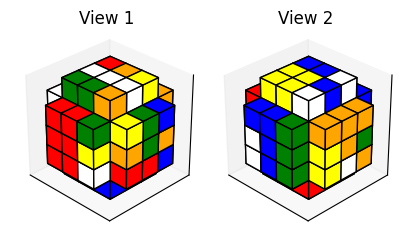


solving...
moves predicted by the model to solve the cube:
[('back', True), ('left', True), ('bottom', True), ('left', False), ('top', True), ('front', True), ('bottom', False)]


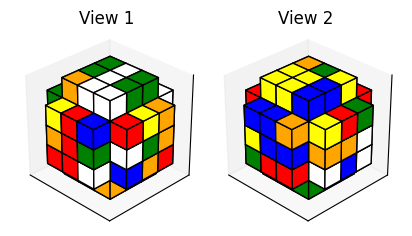

In [ ]:
def predict_and_execute(cube, max_iter = 21):

    #turning rubiks cube into encoder input
    model_X = torch.tensor(tokenize(cube.cube)).to(torch.int32).unsqueeze(0).to(device)

    #input to decoder initialized as a vector of zeros, which is the start token
    model_y = torch.zeros(22).unsqueeze(0).to(torch.int32).to(device)
    current_index = 0

    mask = model_y<-1

    #predicting move sequence
    while current_index < max_iter:
        y_pred = model(model_X, model_y, mask)
        predicted_tokens = torch.argmax(y_pred, dim=-1)
        predicted_next_token = predicted_tokens[0,current_index]
        model_y[0,current_index+1] = predicted_next_token
        current_index+=1

    #converting into a list of moves
    predicted_tokens = model_y.cpu().numpy()[0]

    #executing move sequence
    moves = []
    for token in predicted_tokens:

        #start token
        if token == 0: continue

        #pad token
        if token == 3: continue

        #end token
        if token == 1: break

        #move
        move = output_index_to_move(token-3) #accounting for start, pad, and end
        cube.rotate_face(move[0], reverse=move[1])
        moves.append(move)

    return moves

#we can define how many shuffles we'll use for this particular test
NUMBER_OF_SHUFFLES = 7

print(f'attempting to solve a Rubiks Cube with {NUMBER_OF_SHUFFLES} scrambling moves\n')

#creating a cube
cube = RubiksCube()

#shuffling (changing n will change the number of moves to scramble the cube)
moves = scramble(cube, n=NUMBER_OF_SHUFFLES)
print(f'moves to scramble the cube:\n{moves}')

# Visualize from opposite corners
fig = cube.visualize_opposite_corners(return_fig = True)
fig.set_size_inches(4, 2)
plt.show()

#trying to solve cube
print('\nsolving...')
solution = predict_and_execute(cube)
print(f'moves predicted by the model to solve the cube:\n{solution}')

# Visualize from opposite corners
fig = cube.visualize_opposite_corners(return_fig = True)
fig.set_size_inches(4, 2)
plt.show()

# Trying iterative passes

In [ ]:
def is_cube_solved(rubiks_cube):
    """
    Checks if the given Rubik's Cube object is solved.

    Parameters:
        rubiks_cube (RubiksCube): An instance of the RubiksCube class.

    Returns:
        bool: True if the cube is solved, False otherwise.
    """
    # Extract the cube data
    cube_data = rubiks_cube.cube

    # Define the face slices corresponding to the cube structure
    face_slices = [
        cube_data[0, 1:-1, 1:-1],  # Top (white)
        cube_data[1:-1, 0, 1:-1],  # Front (green)
        cube_data[1:-1, 1:-1, 0],  # Left (red)
        cube_data[-1, 1:-1, 1:-1], # Bottom (yellow)
        cube_data[1:-1, -1, 1:-1], # Back (blue)
        cube_data[1:-1, 1:-1, -1]  # Right (orange)
    ]

    # Check if all faces are uniform
    for face in face_slices:
        unique_colors = np.unique(face)
        if len(unique_colors) != 1:
            return False

    return True

[('right', True), ('front', False), ('left', False), ('right', False), ('bottom', True), ('bottom', True)]


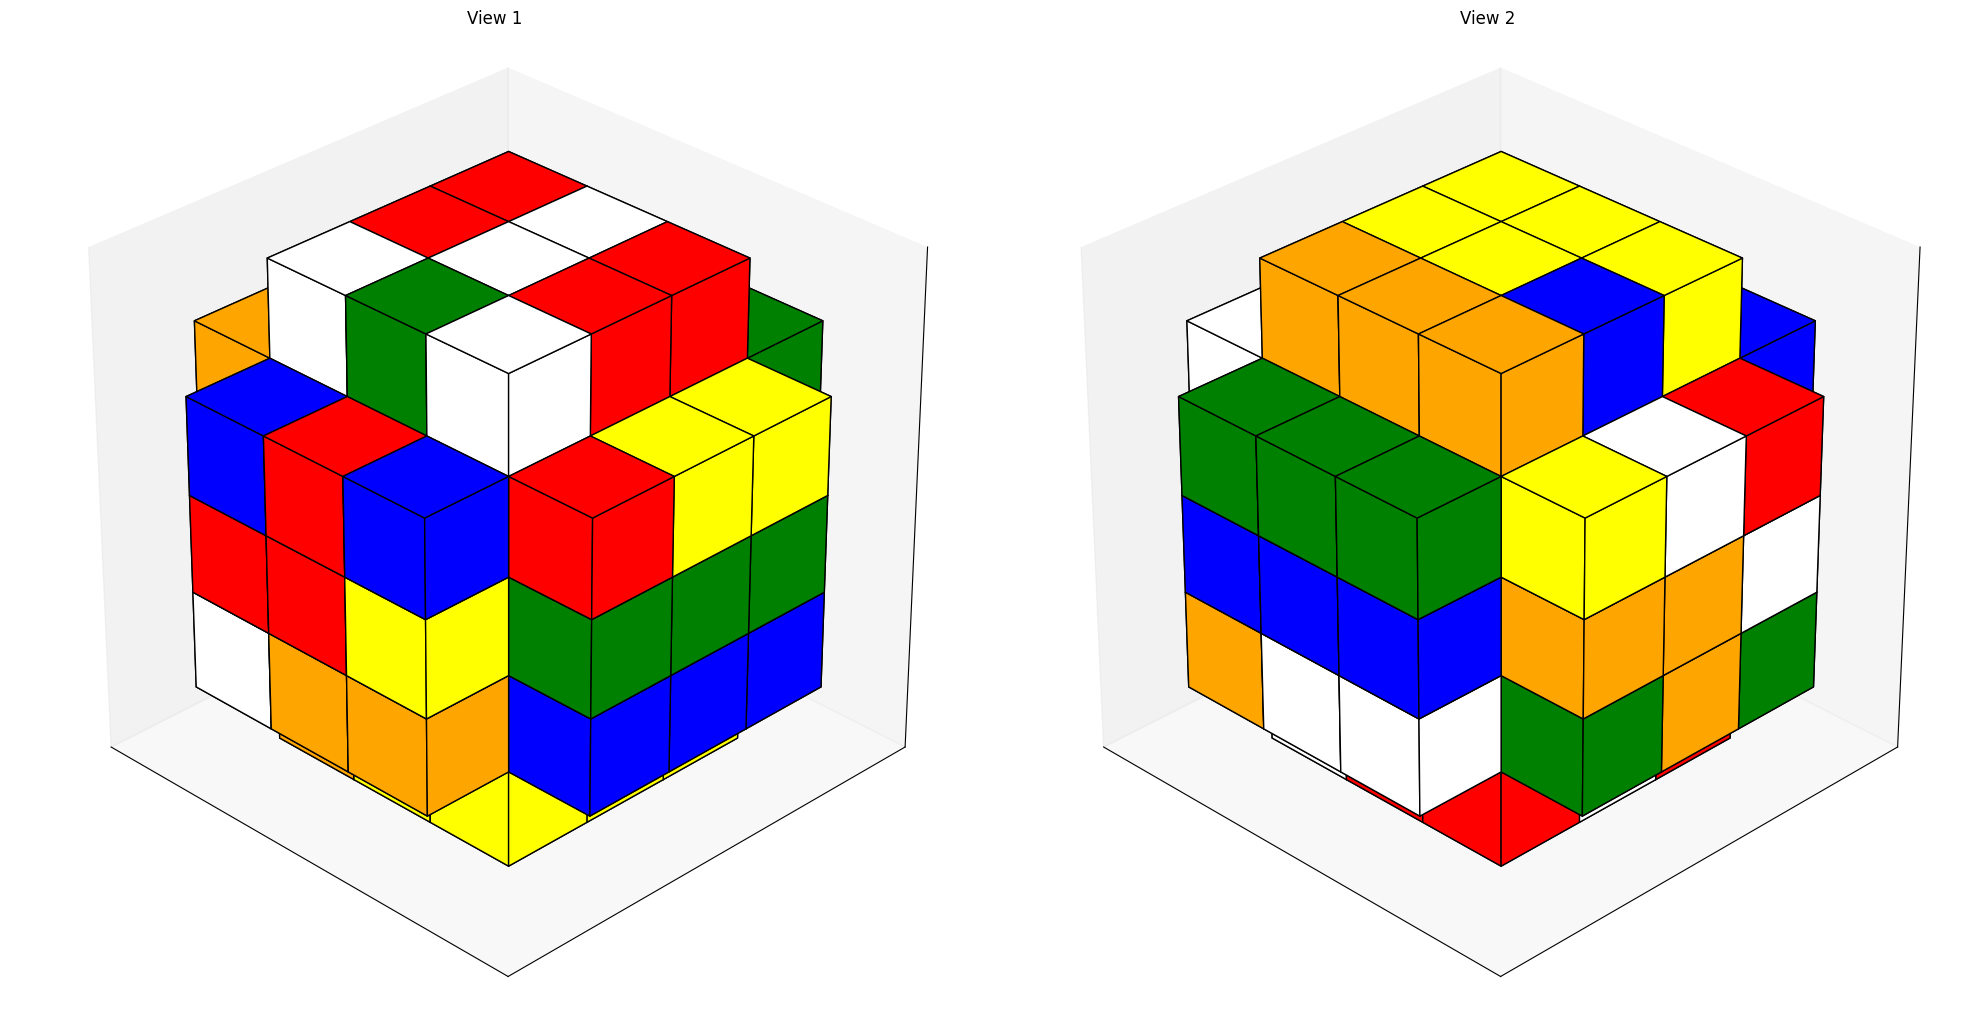

attempt 1/20
solving...


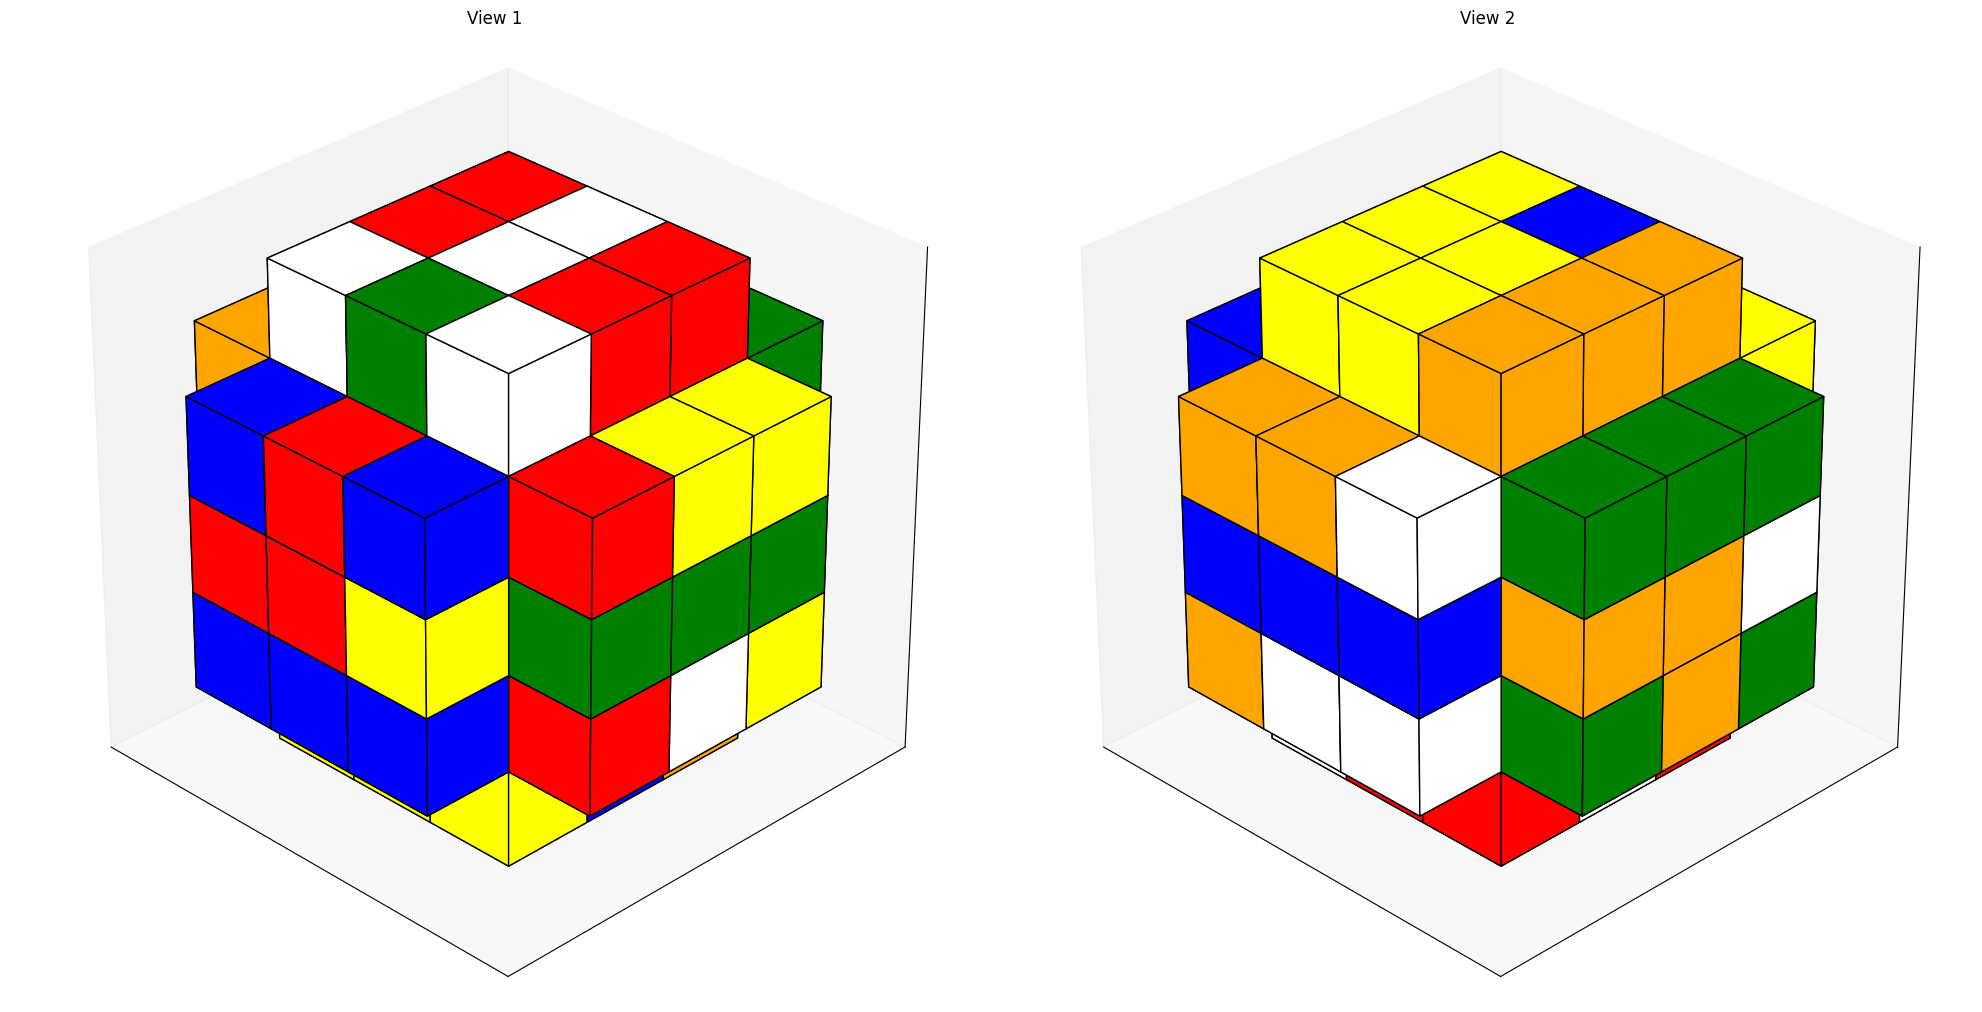

attempt 2/20
solving...


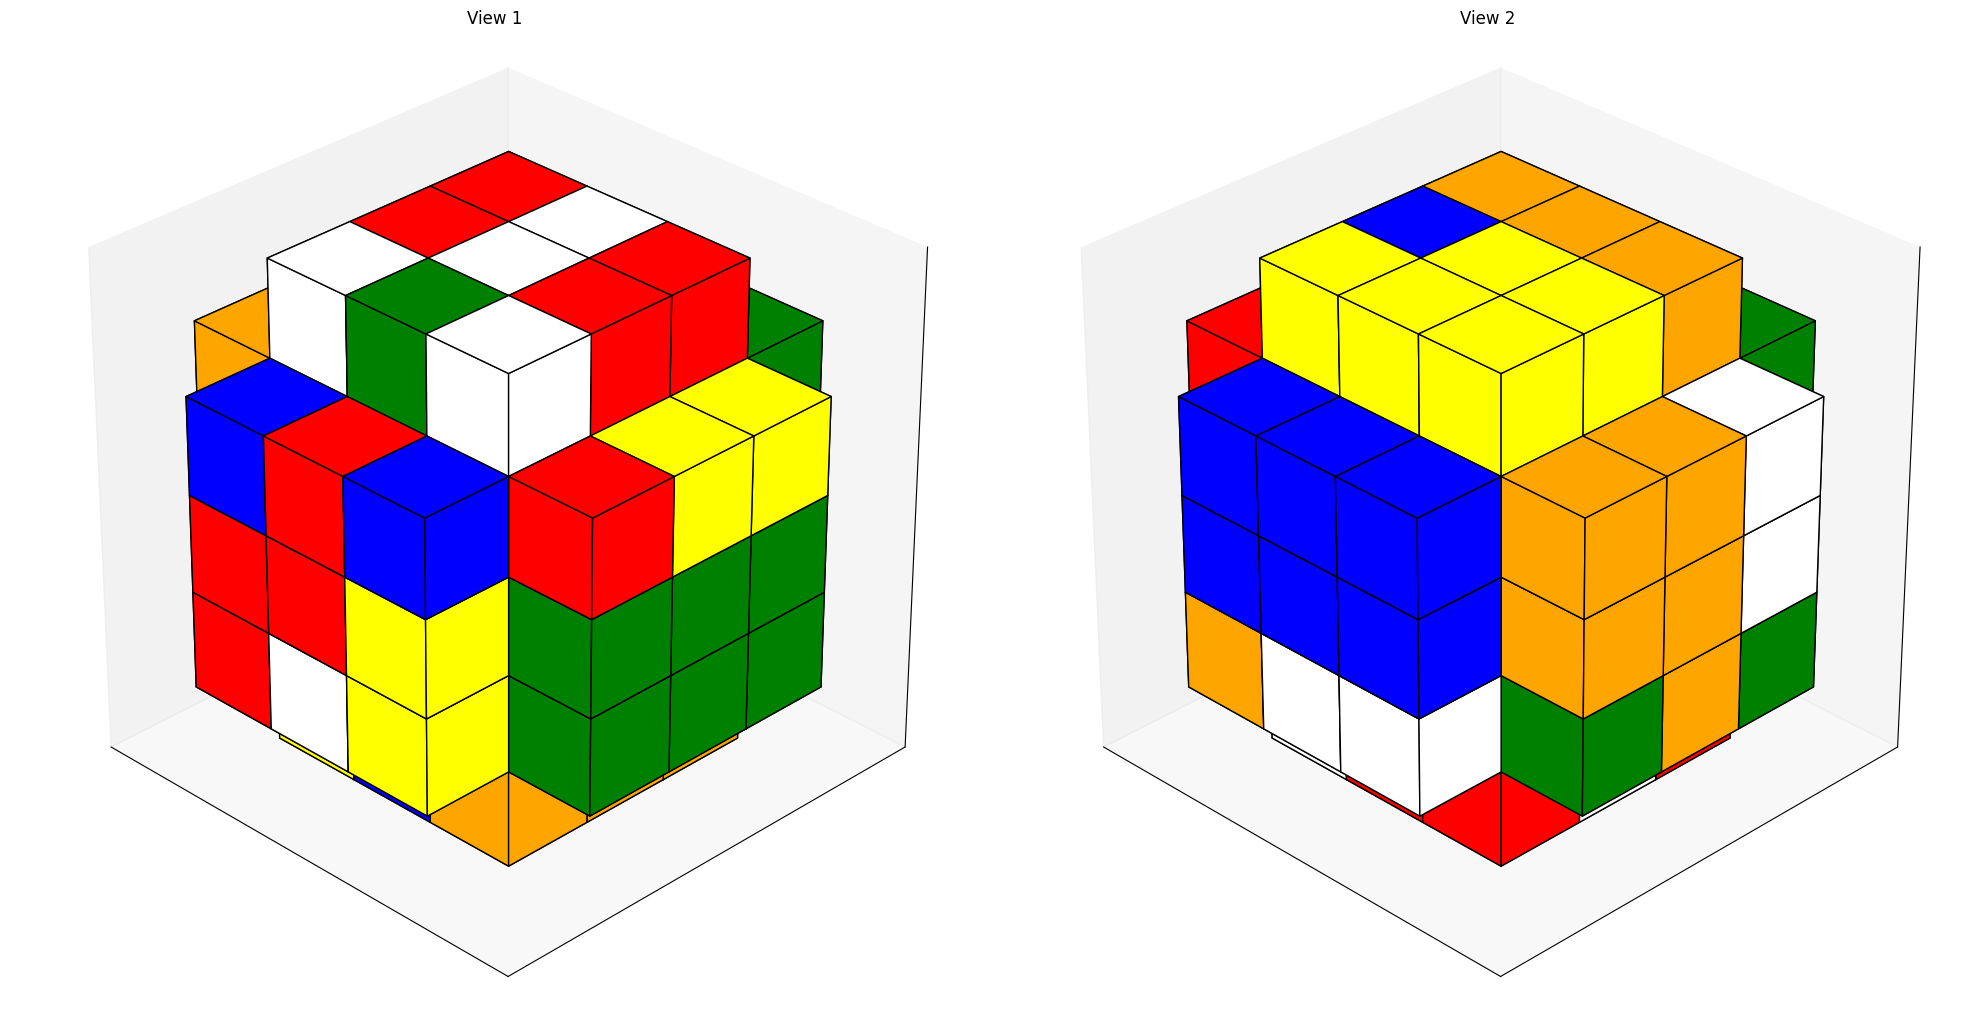

attempt 3/20
solving...


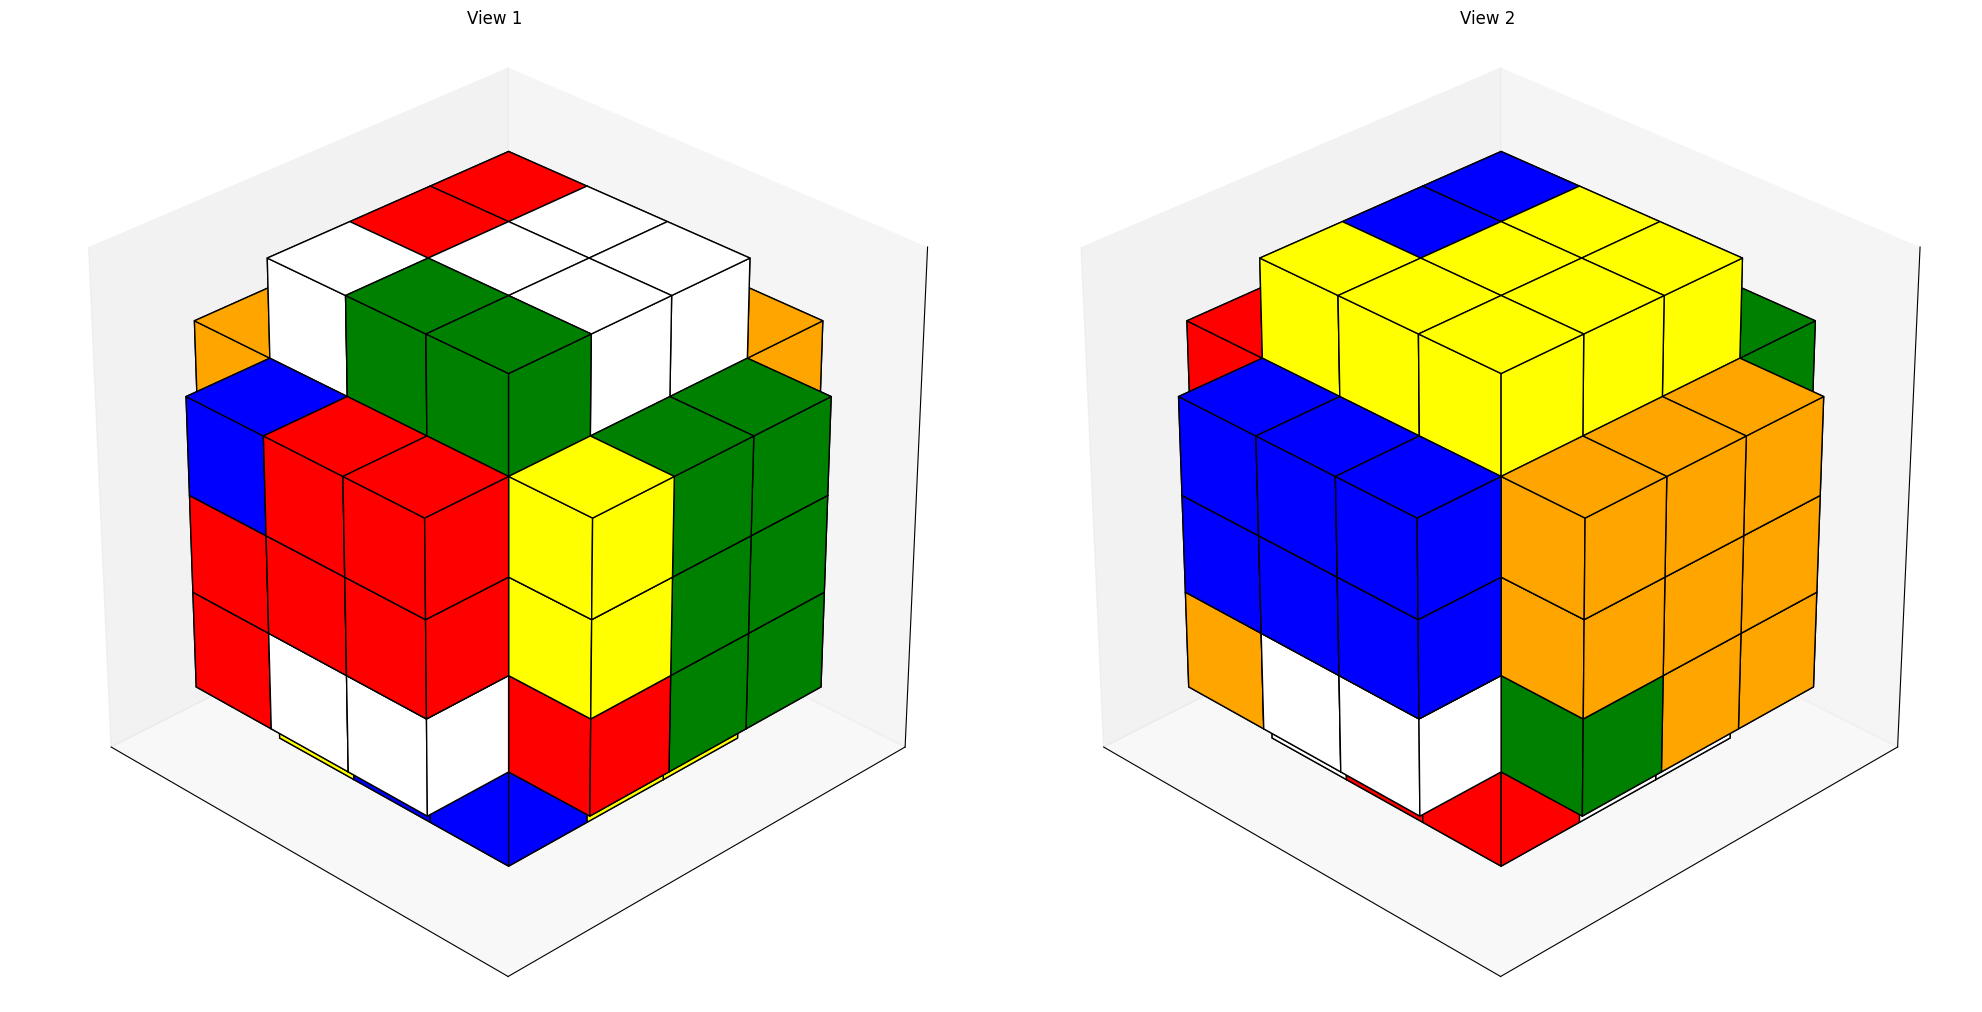

attempt 4/20
solving...


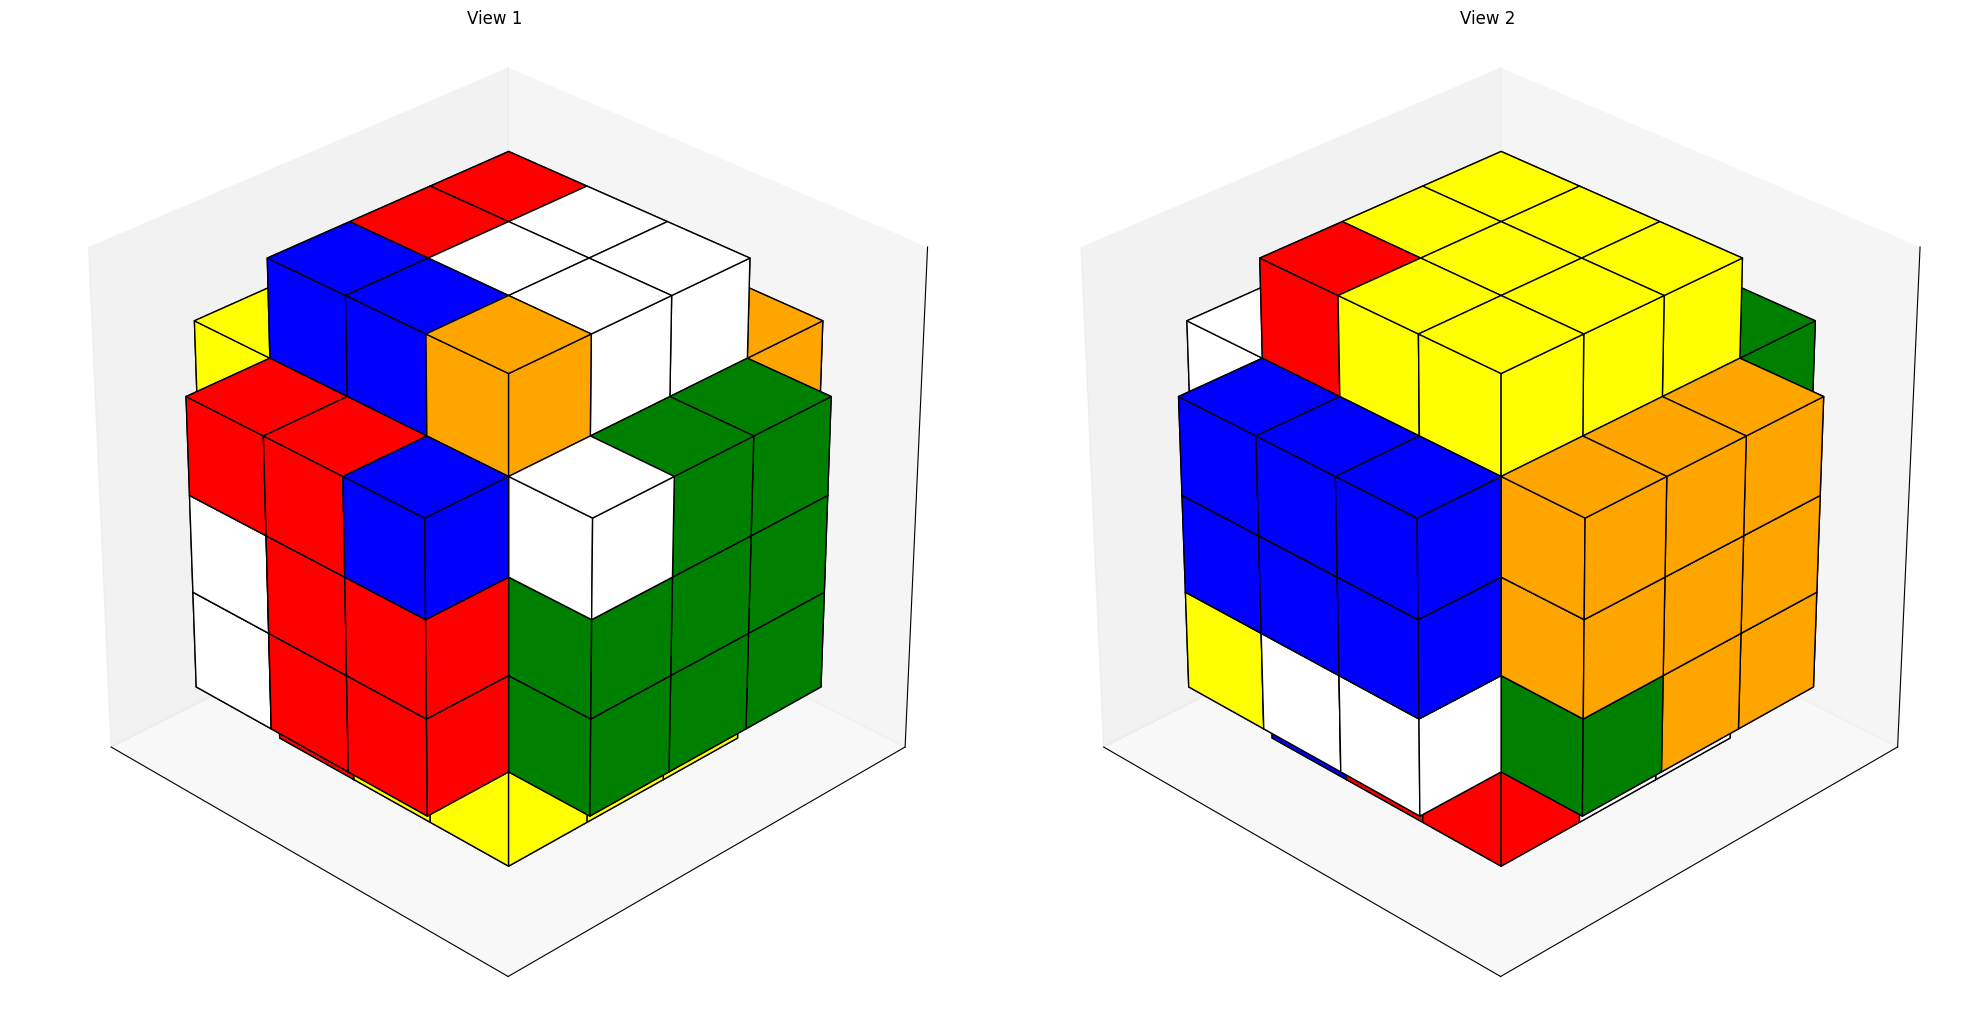

attempt 5/20
solving...


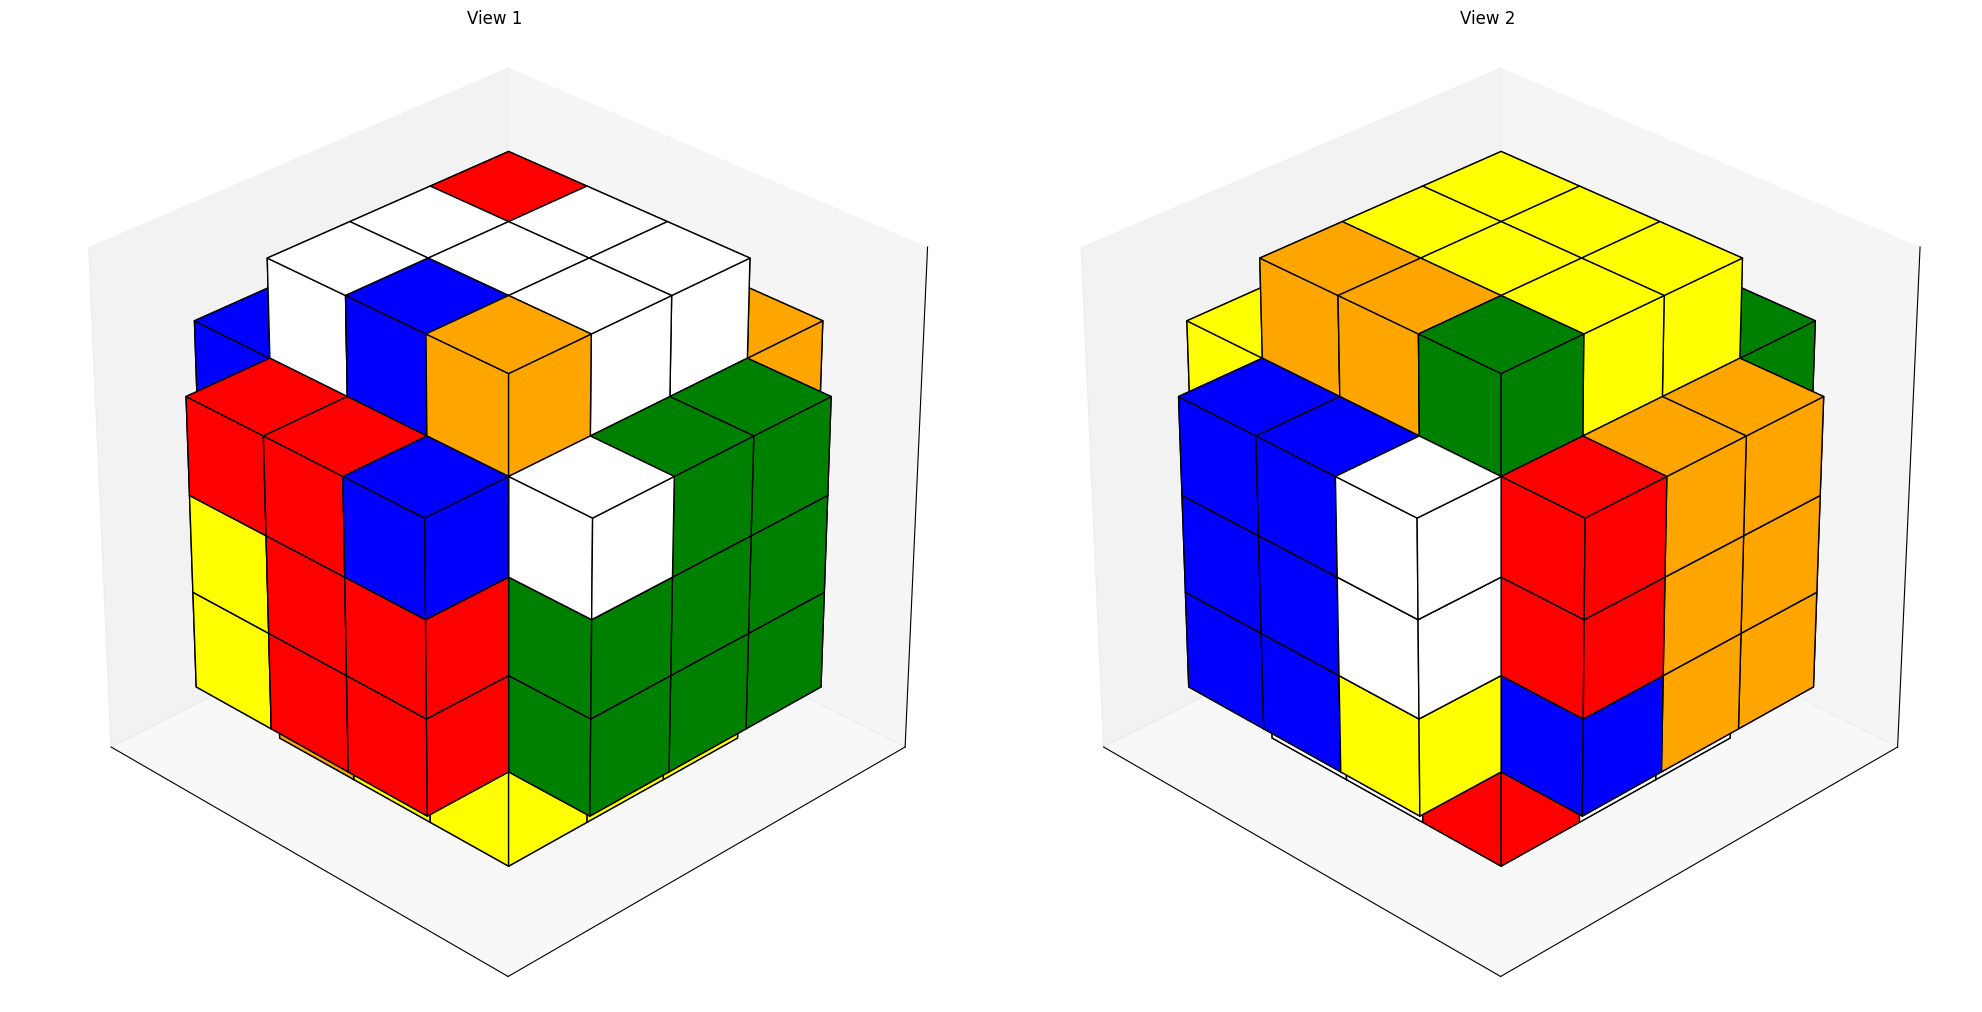

attempt 6/20
solving...


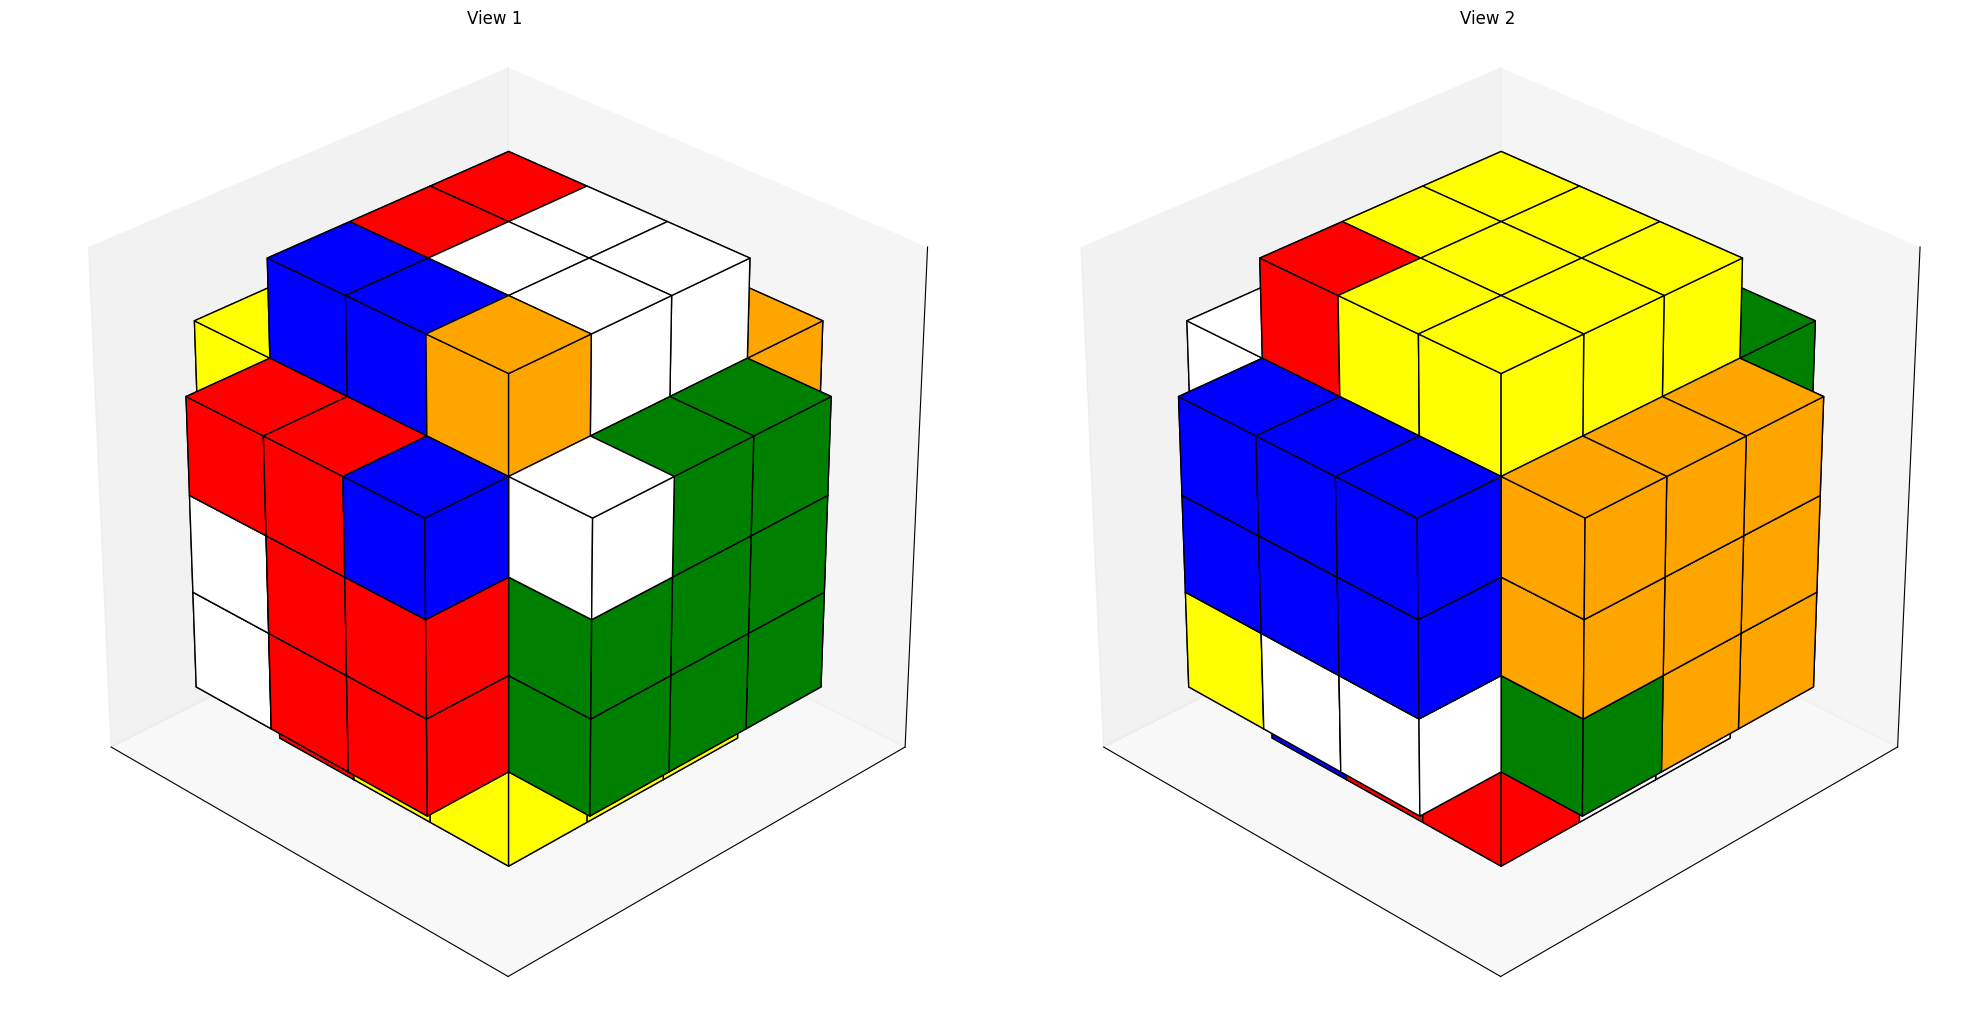

attempt 7/20
solving...


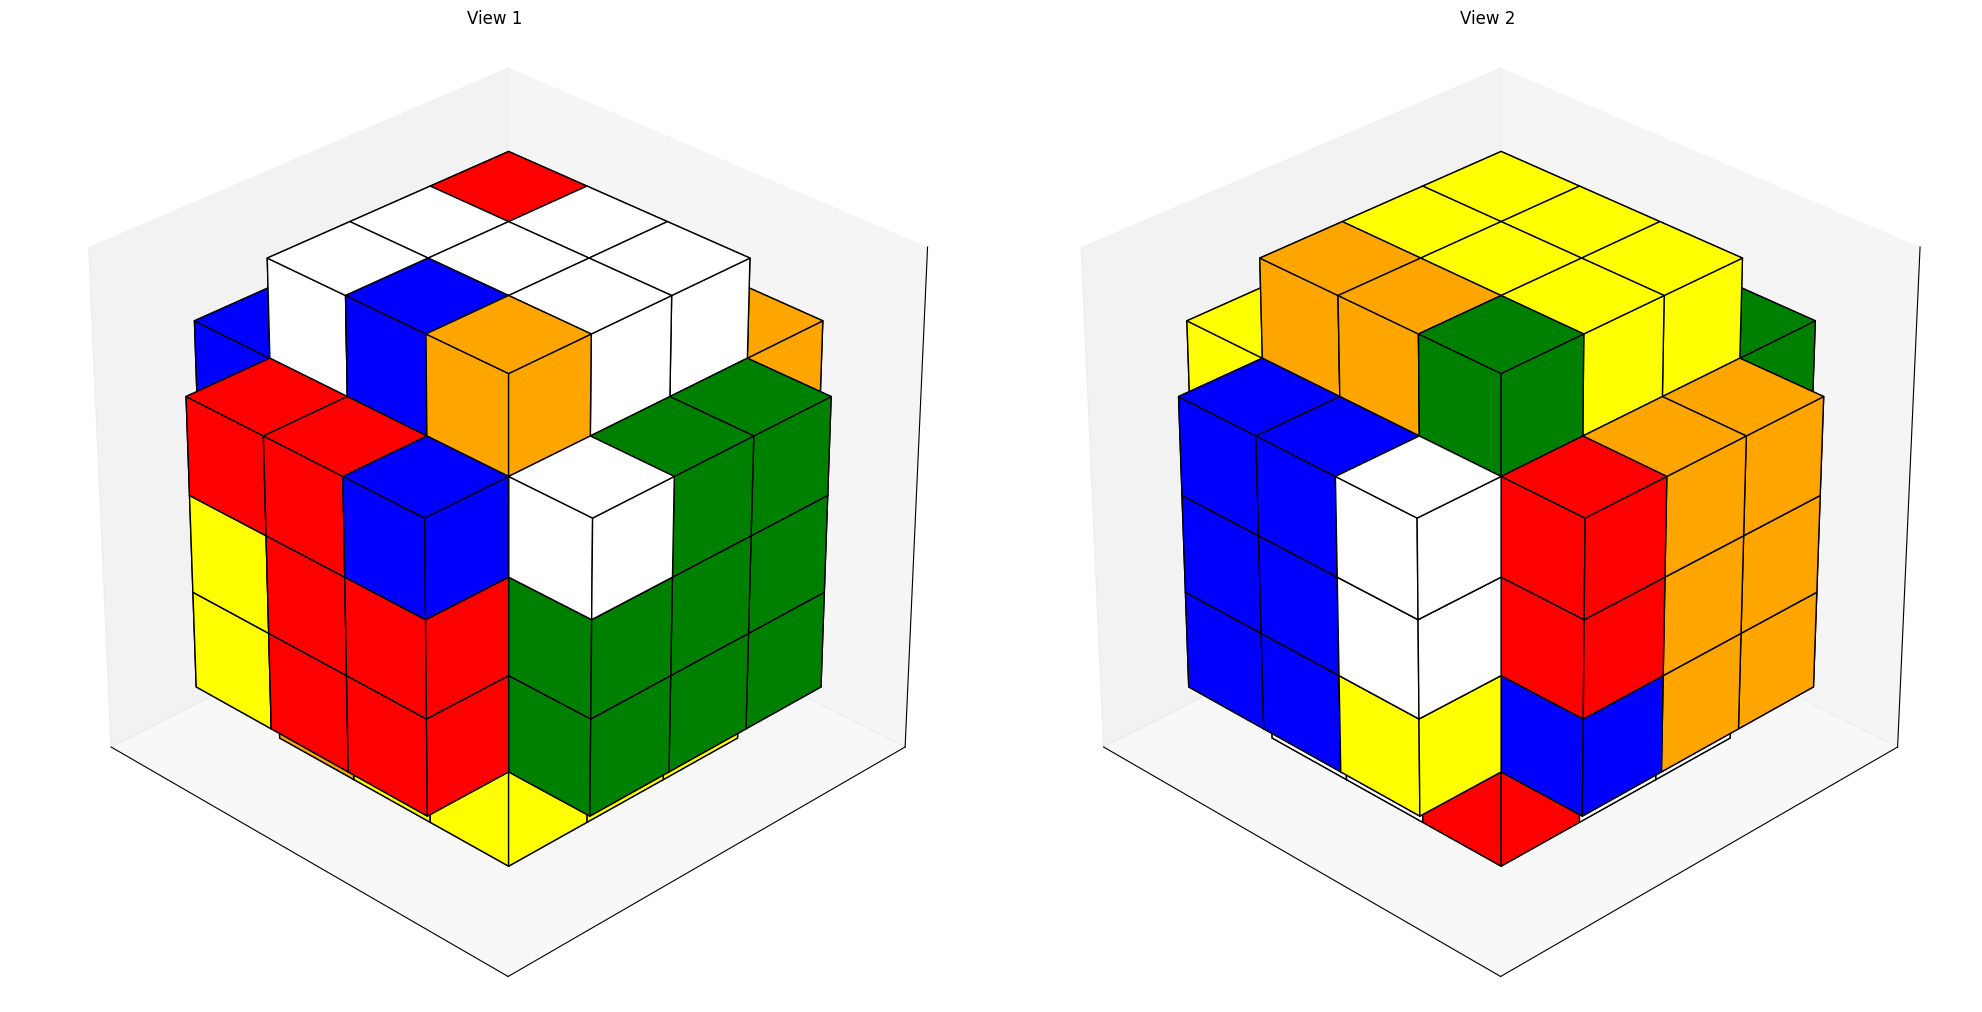

attempt 8/20
solving...


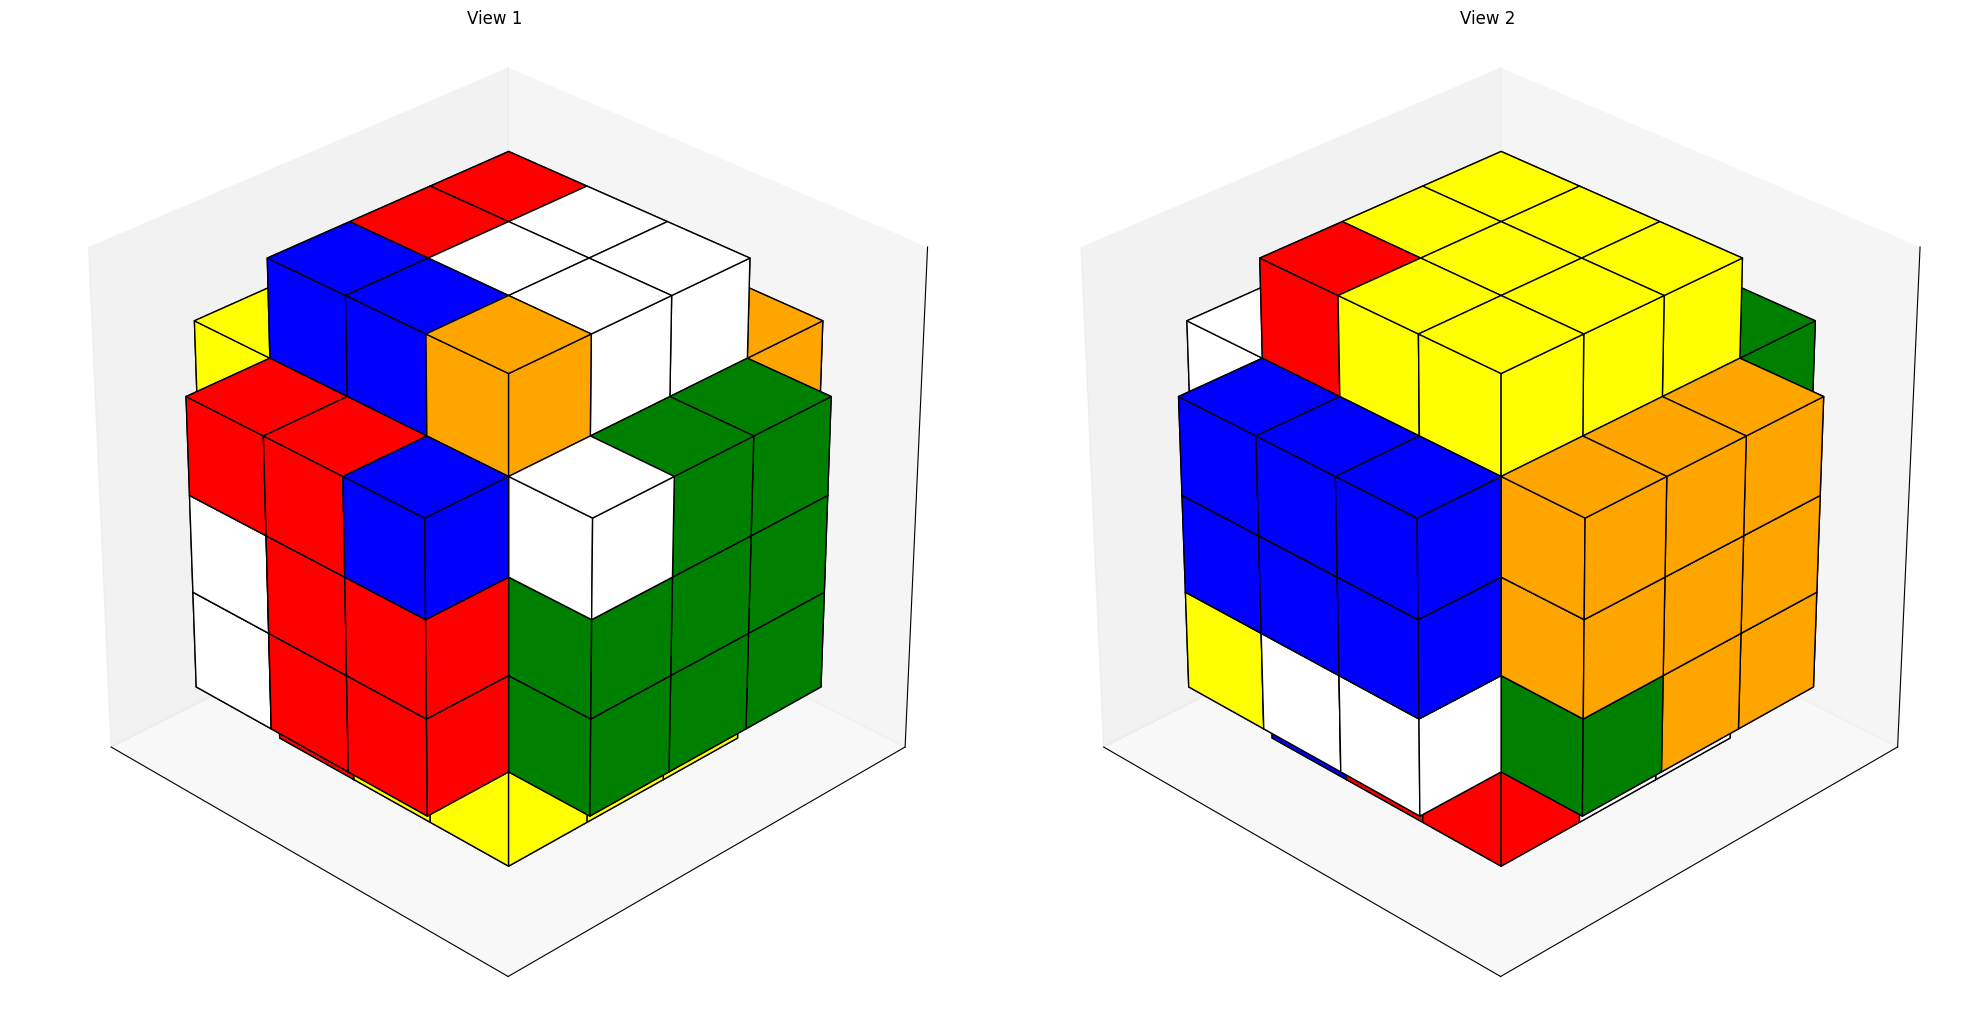

attempt 9/20
solving...


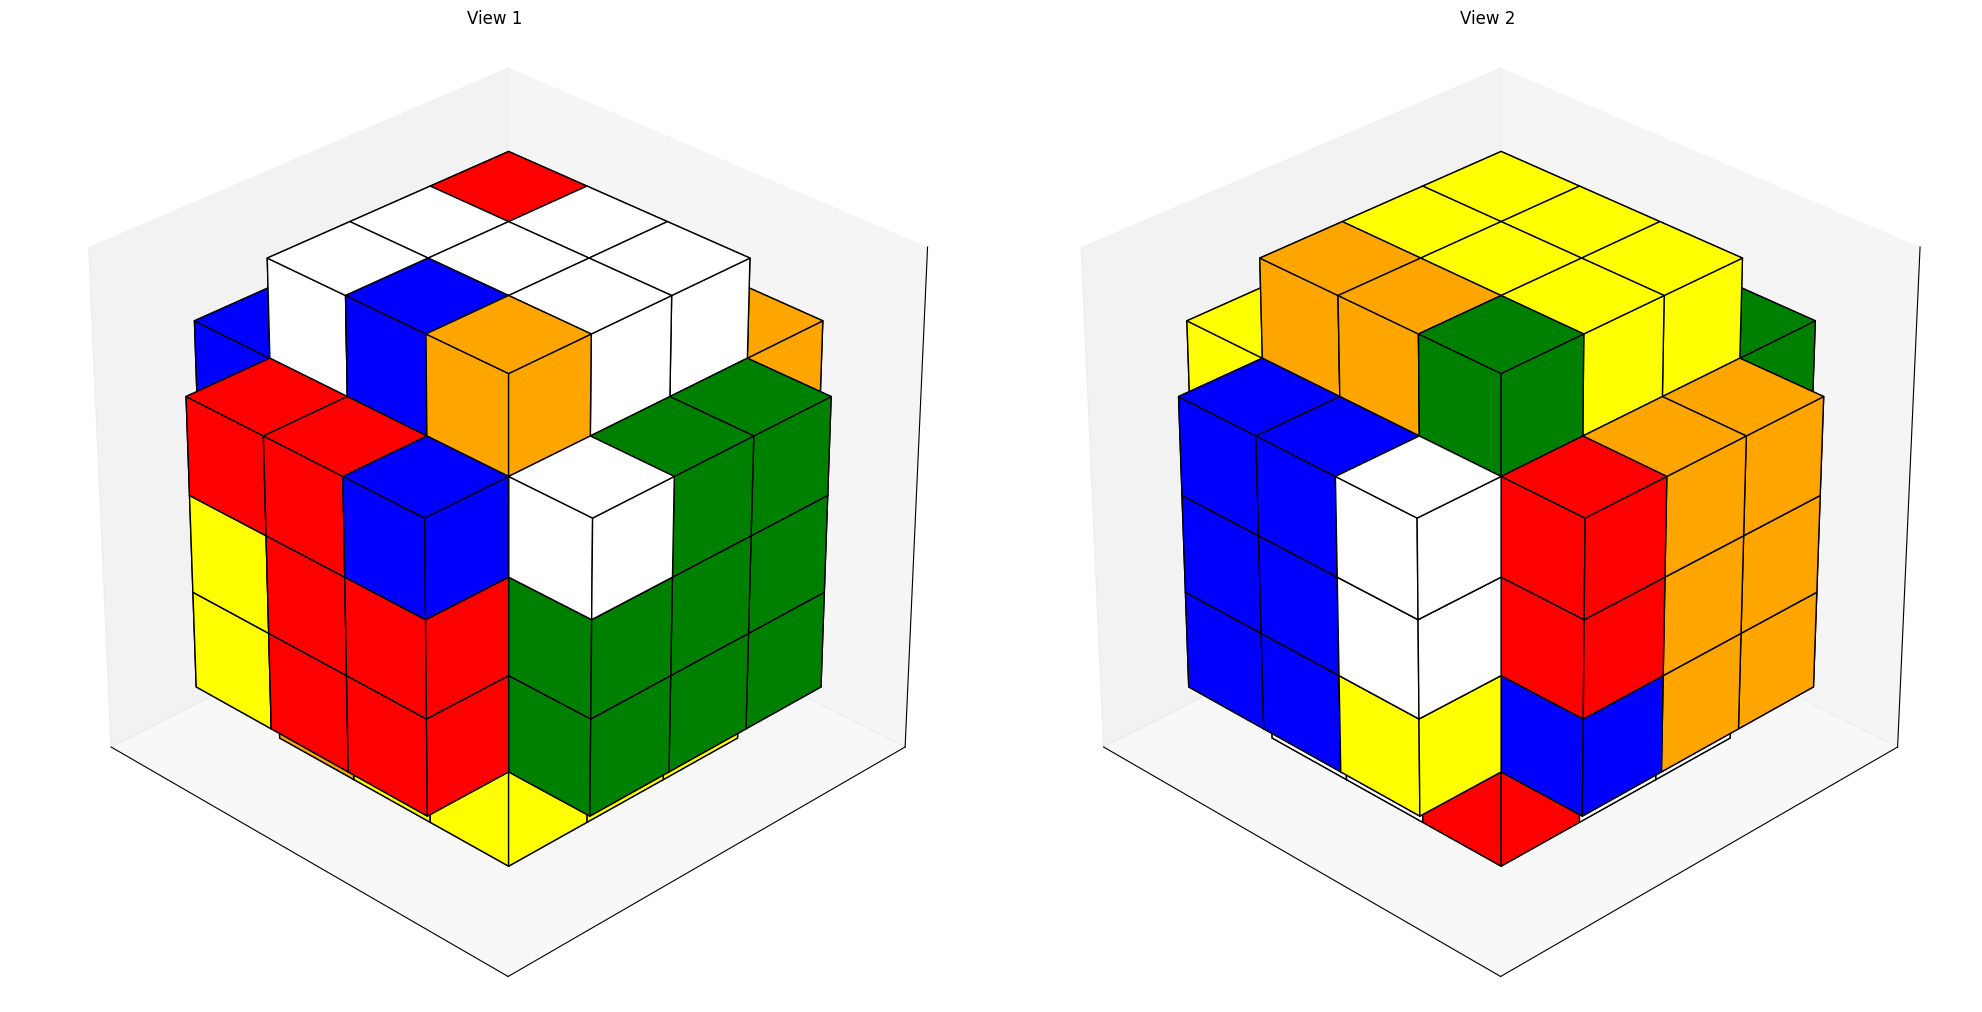

attempt 10/20
solving...


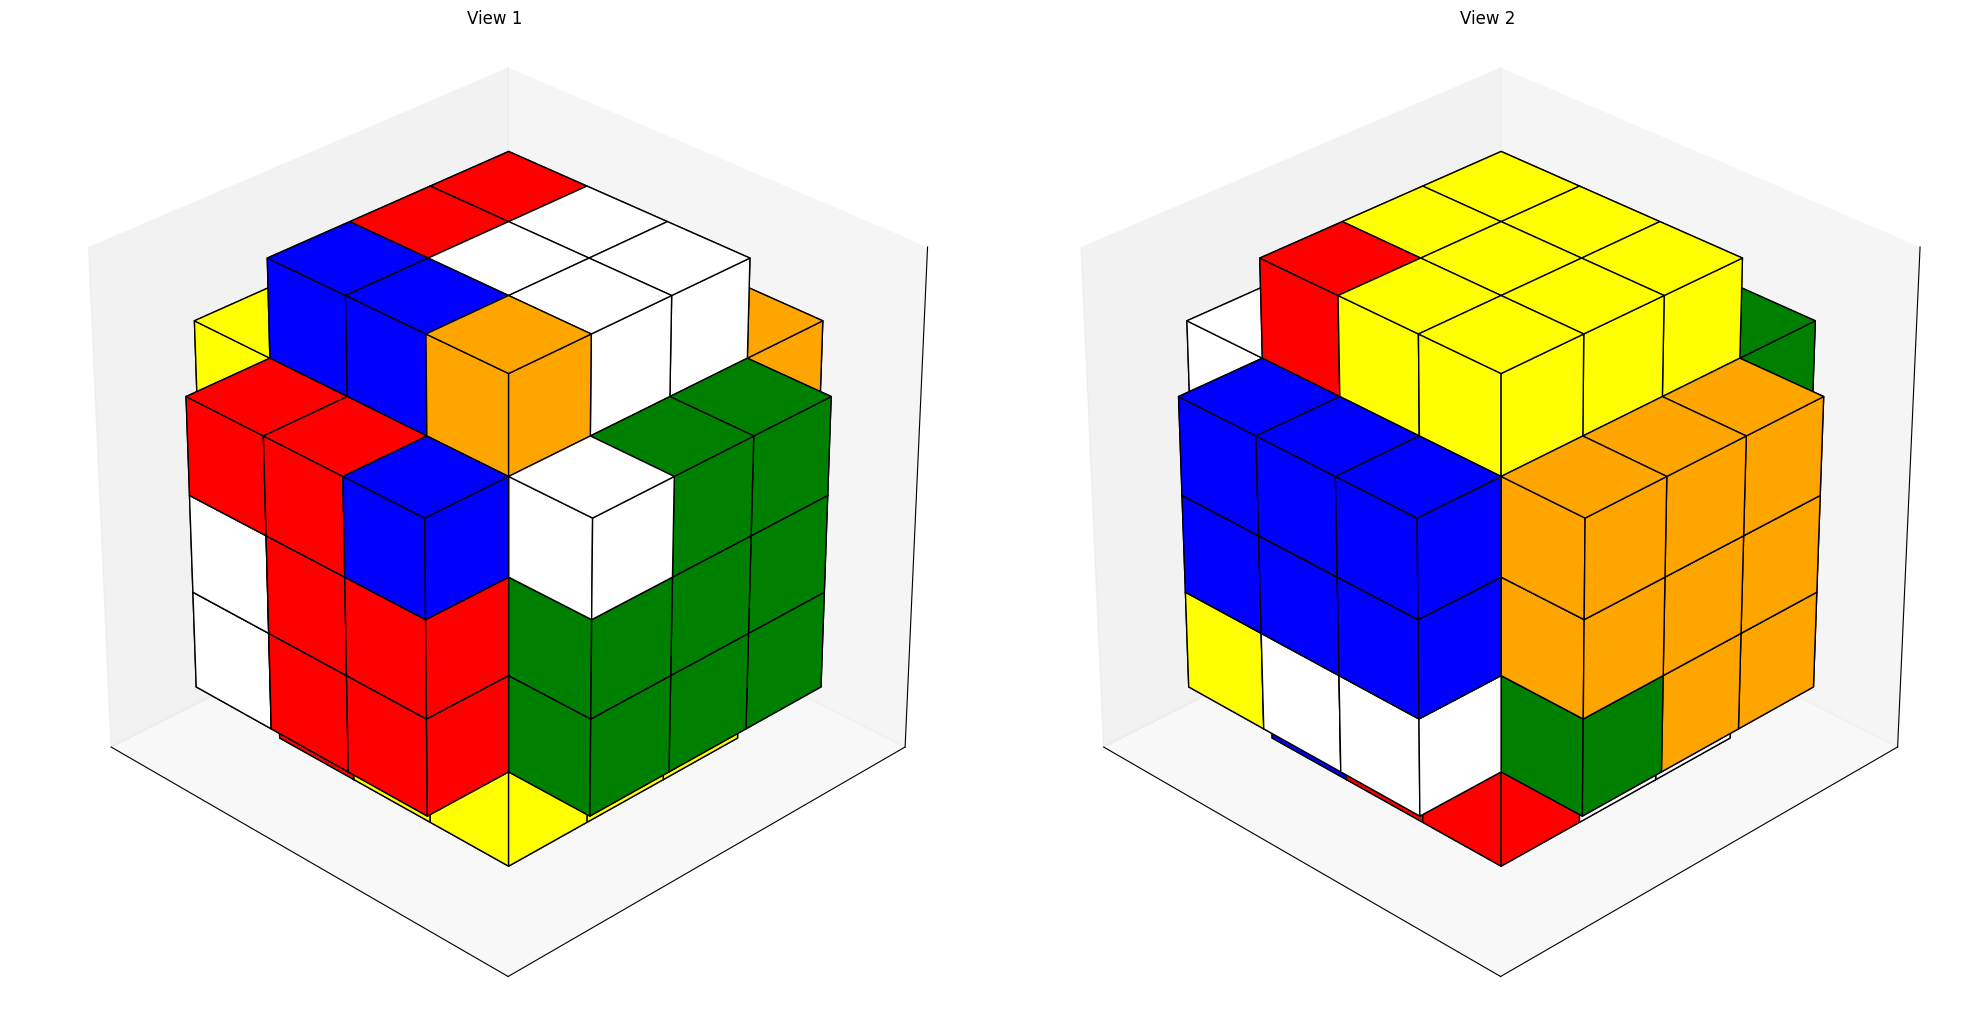

attempt 11/20
solving...


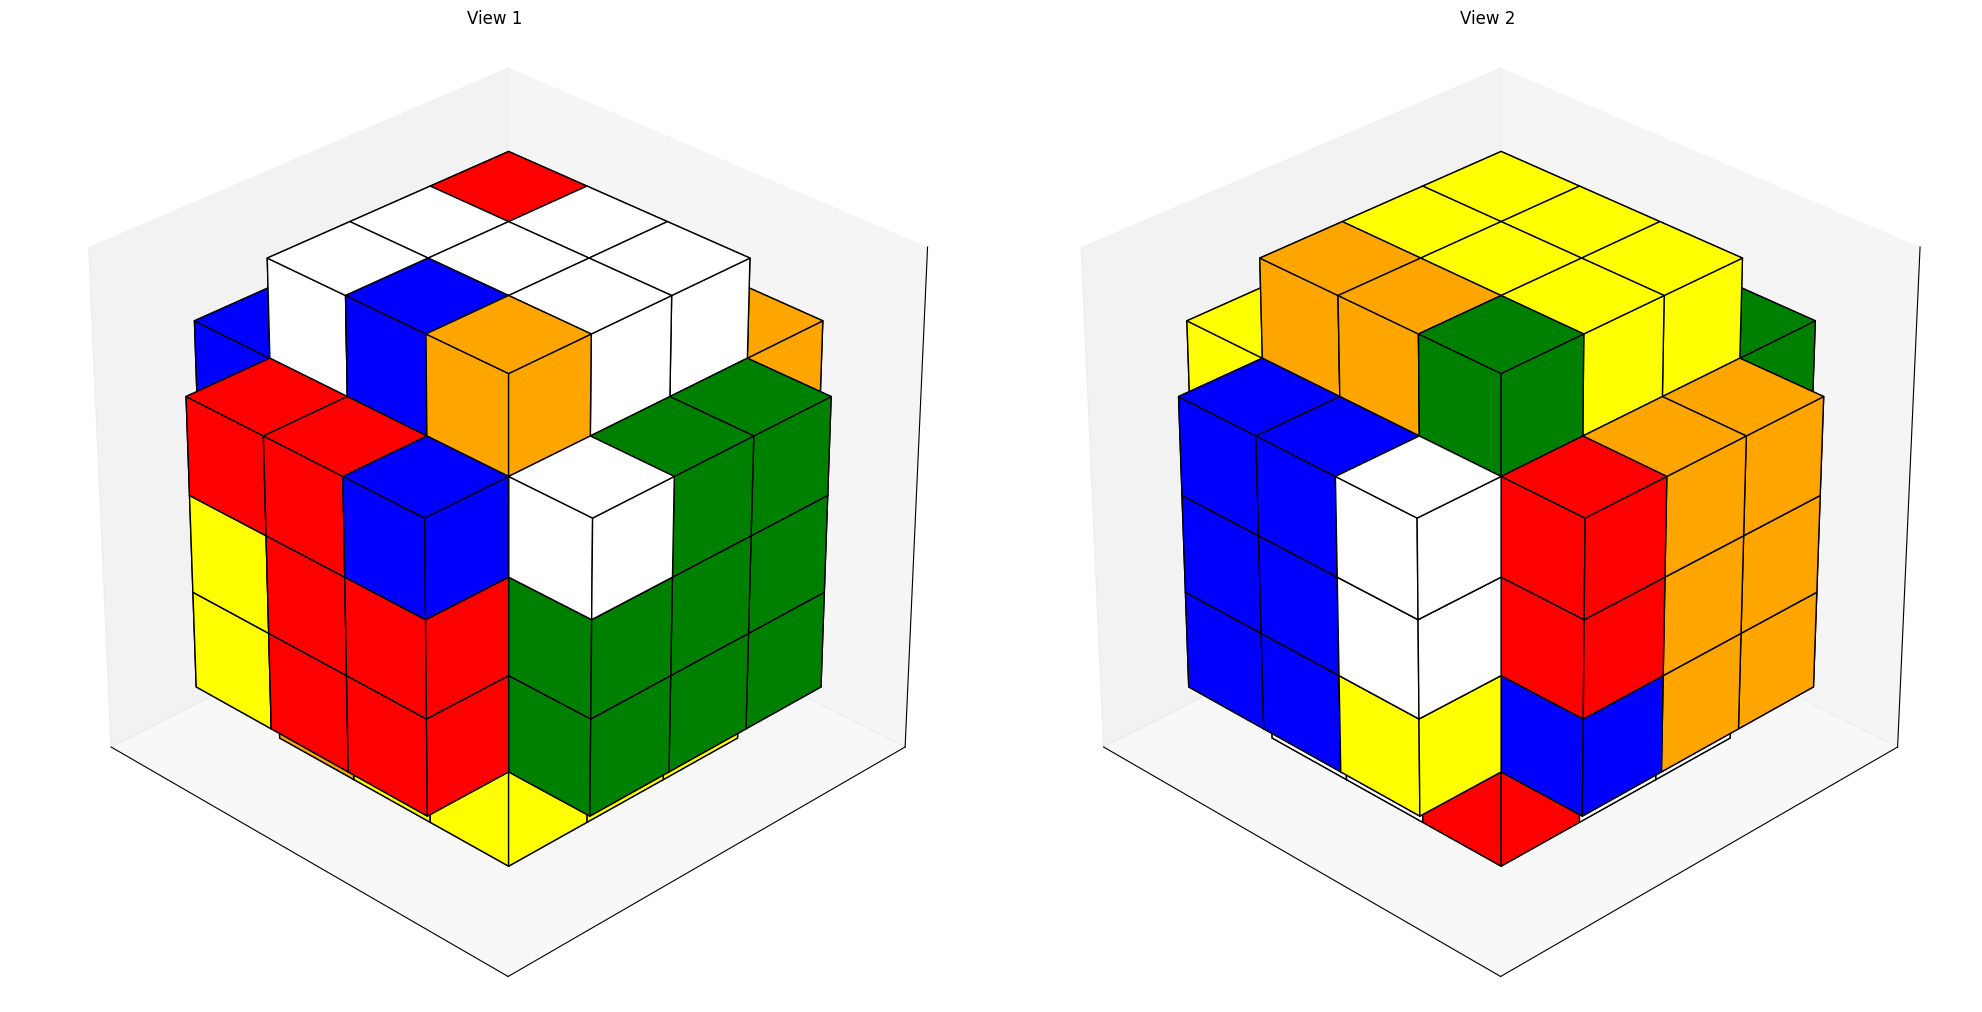

attempt 12/20
solving...


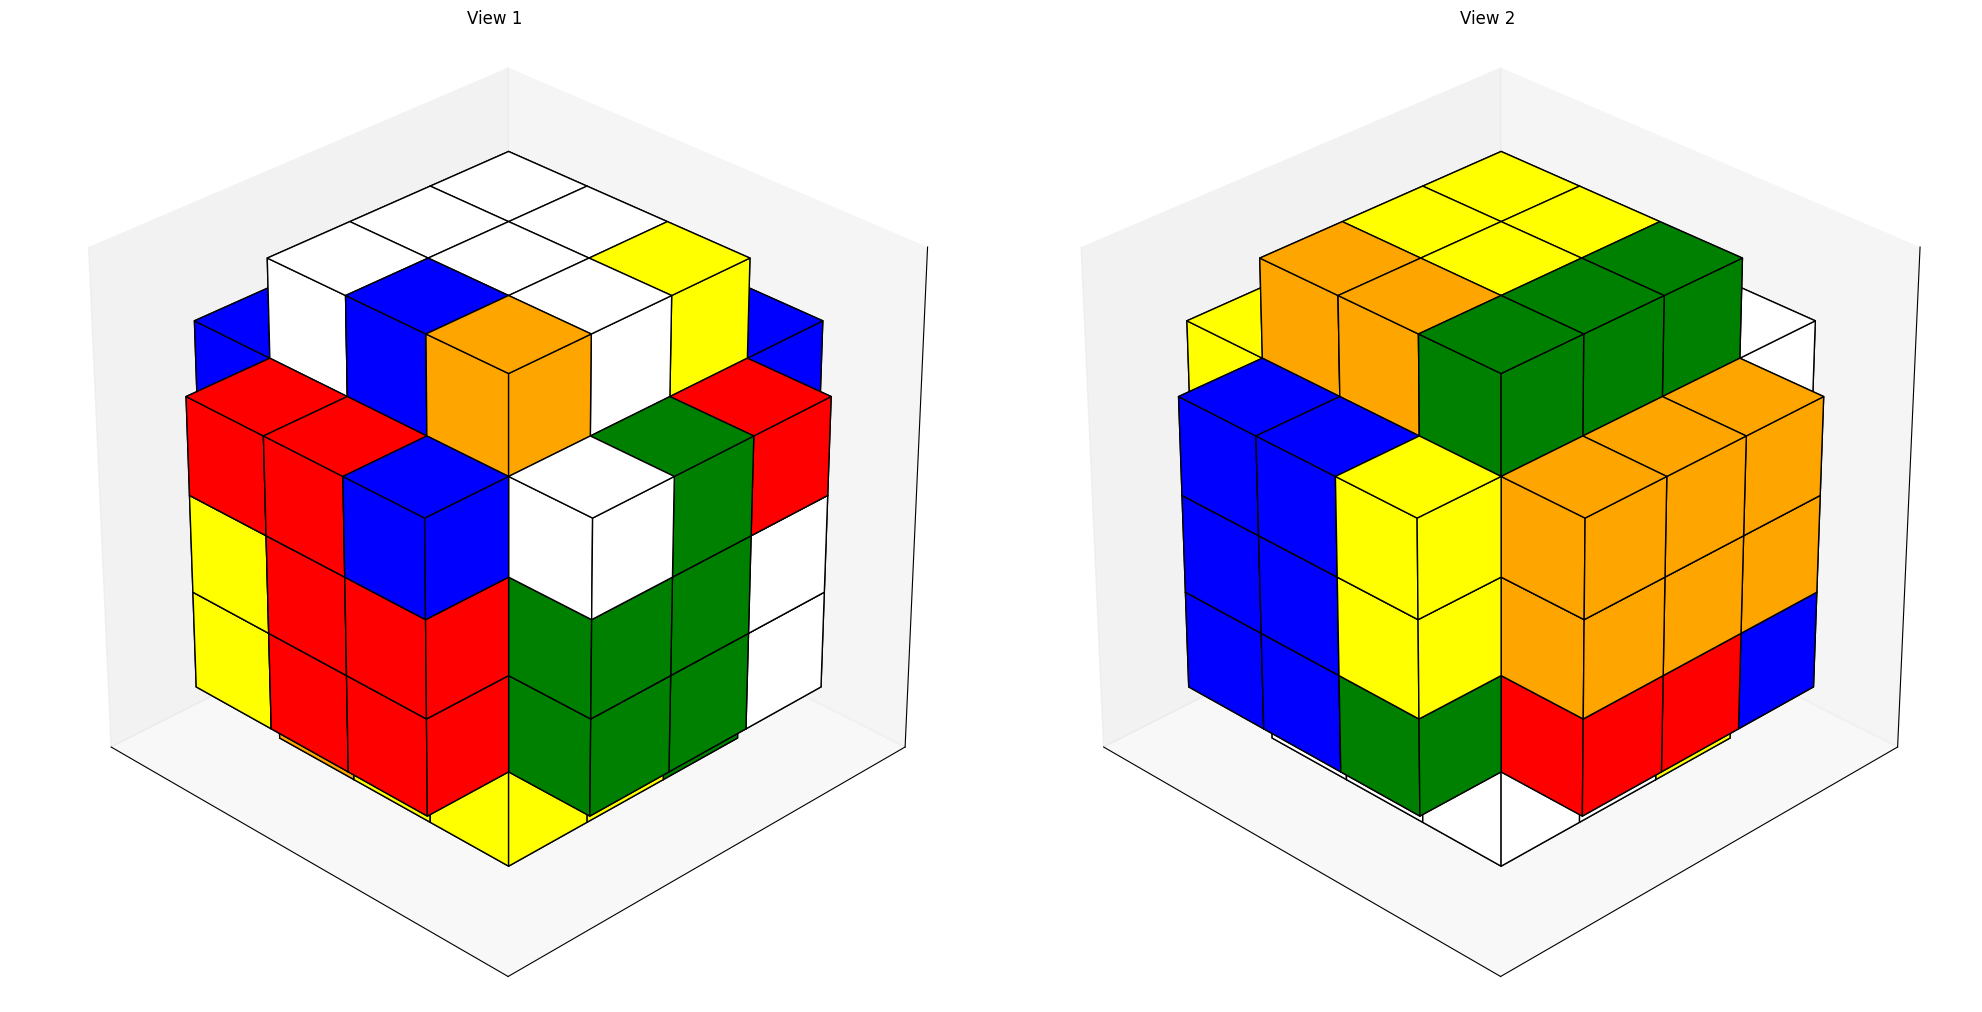

attempt 13/20
solving...


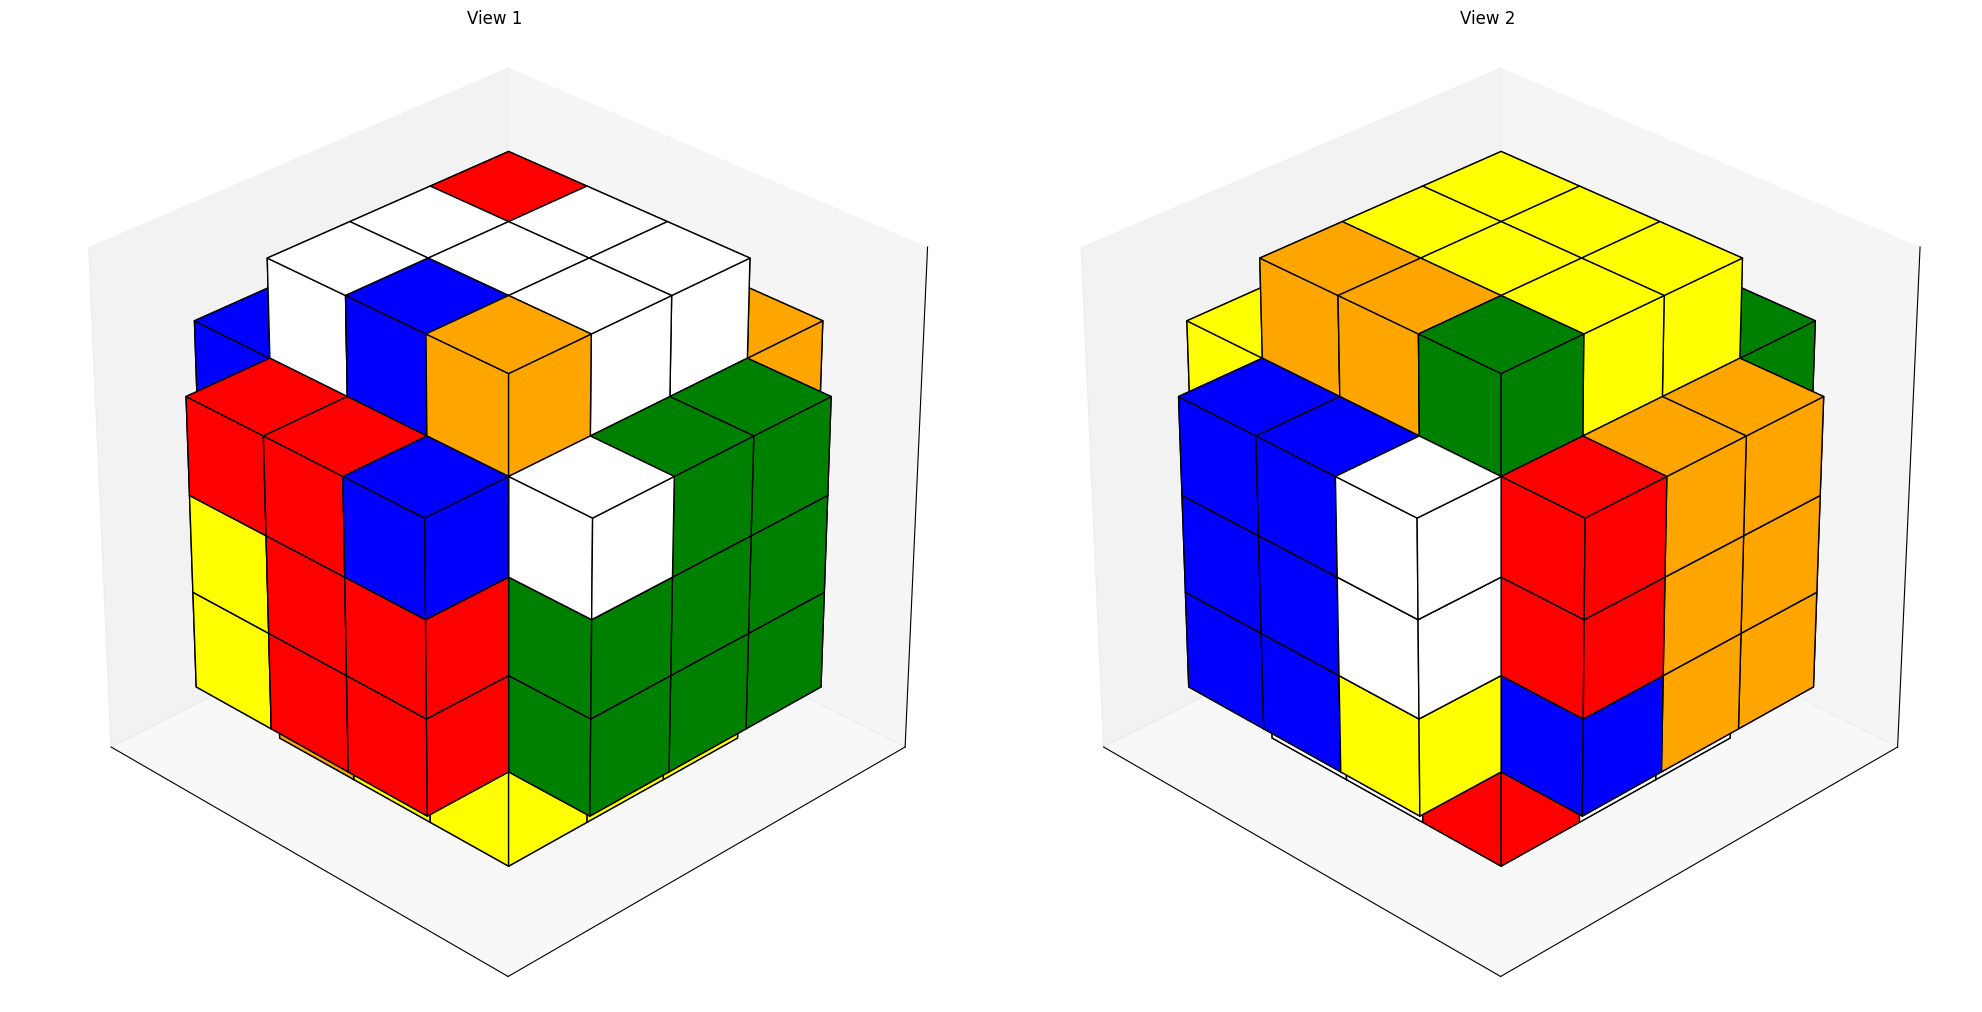

attempt 14/20
solving...


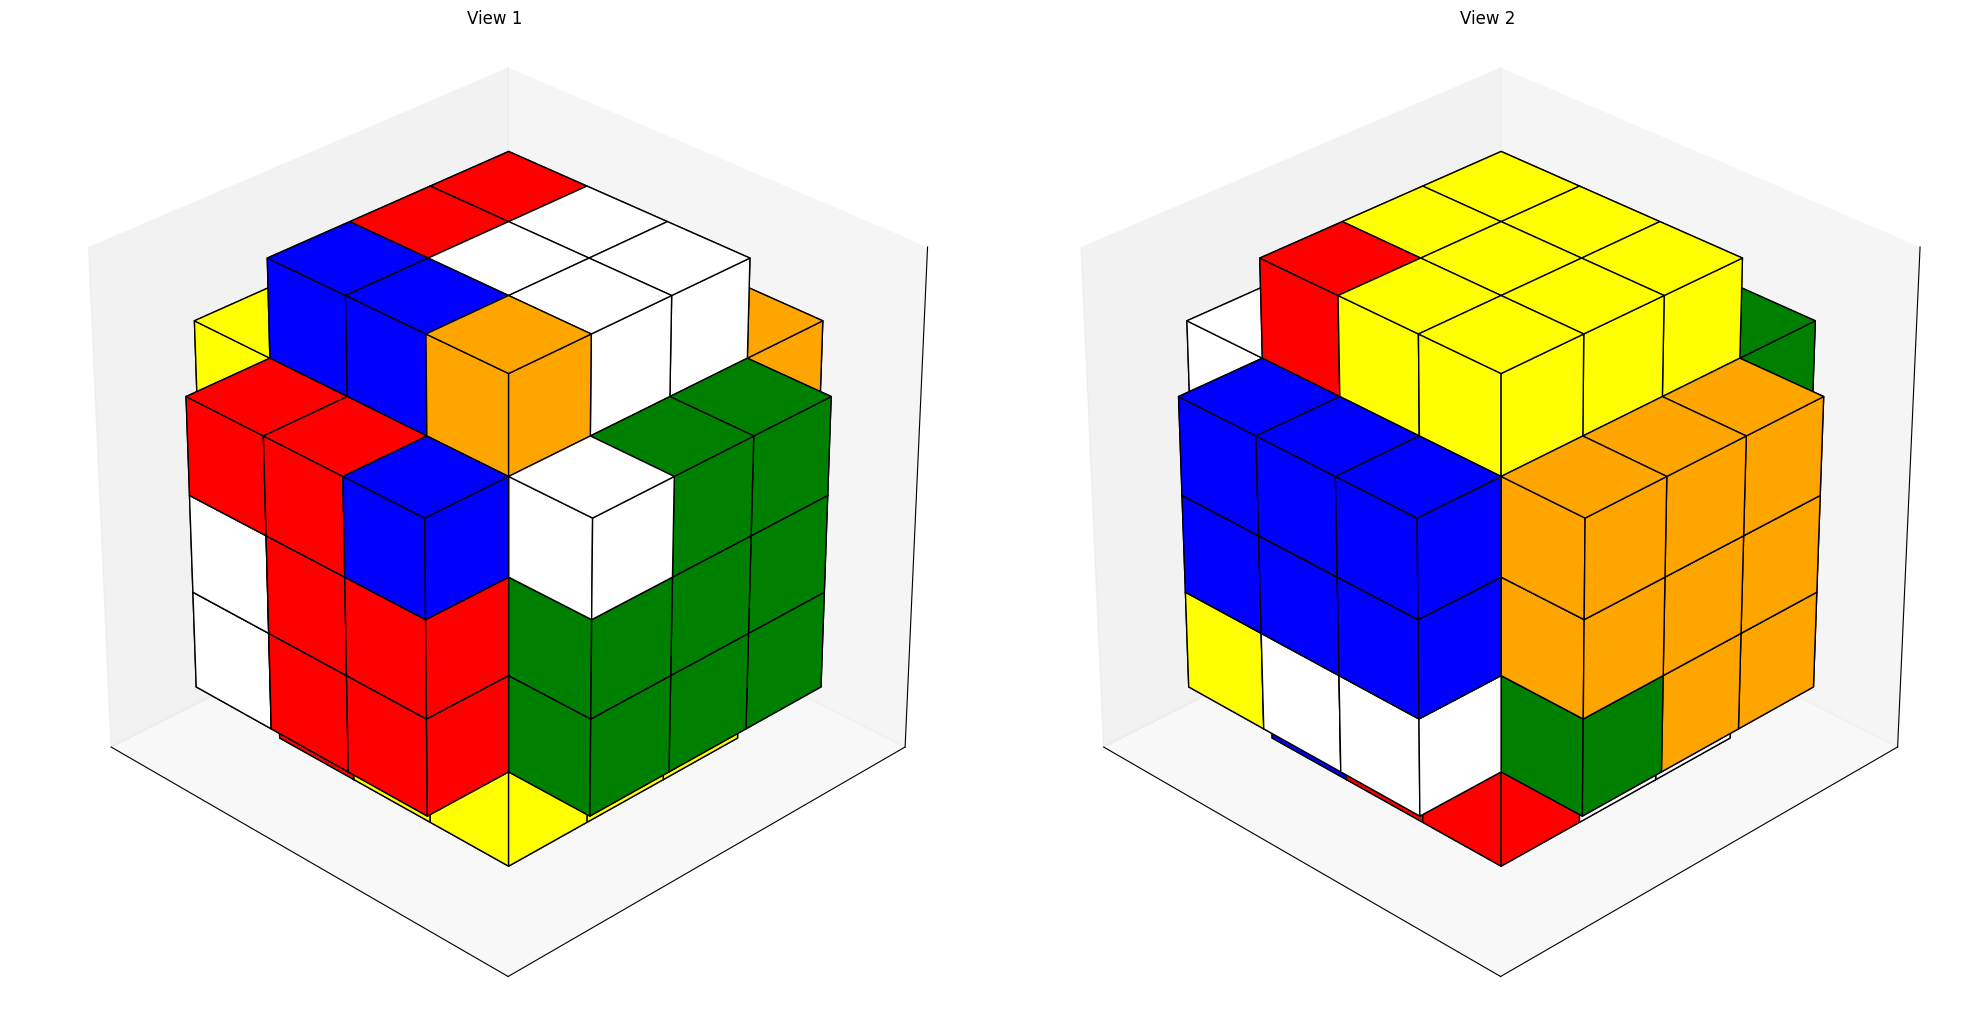

attempt 15/20
solving...


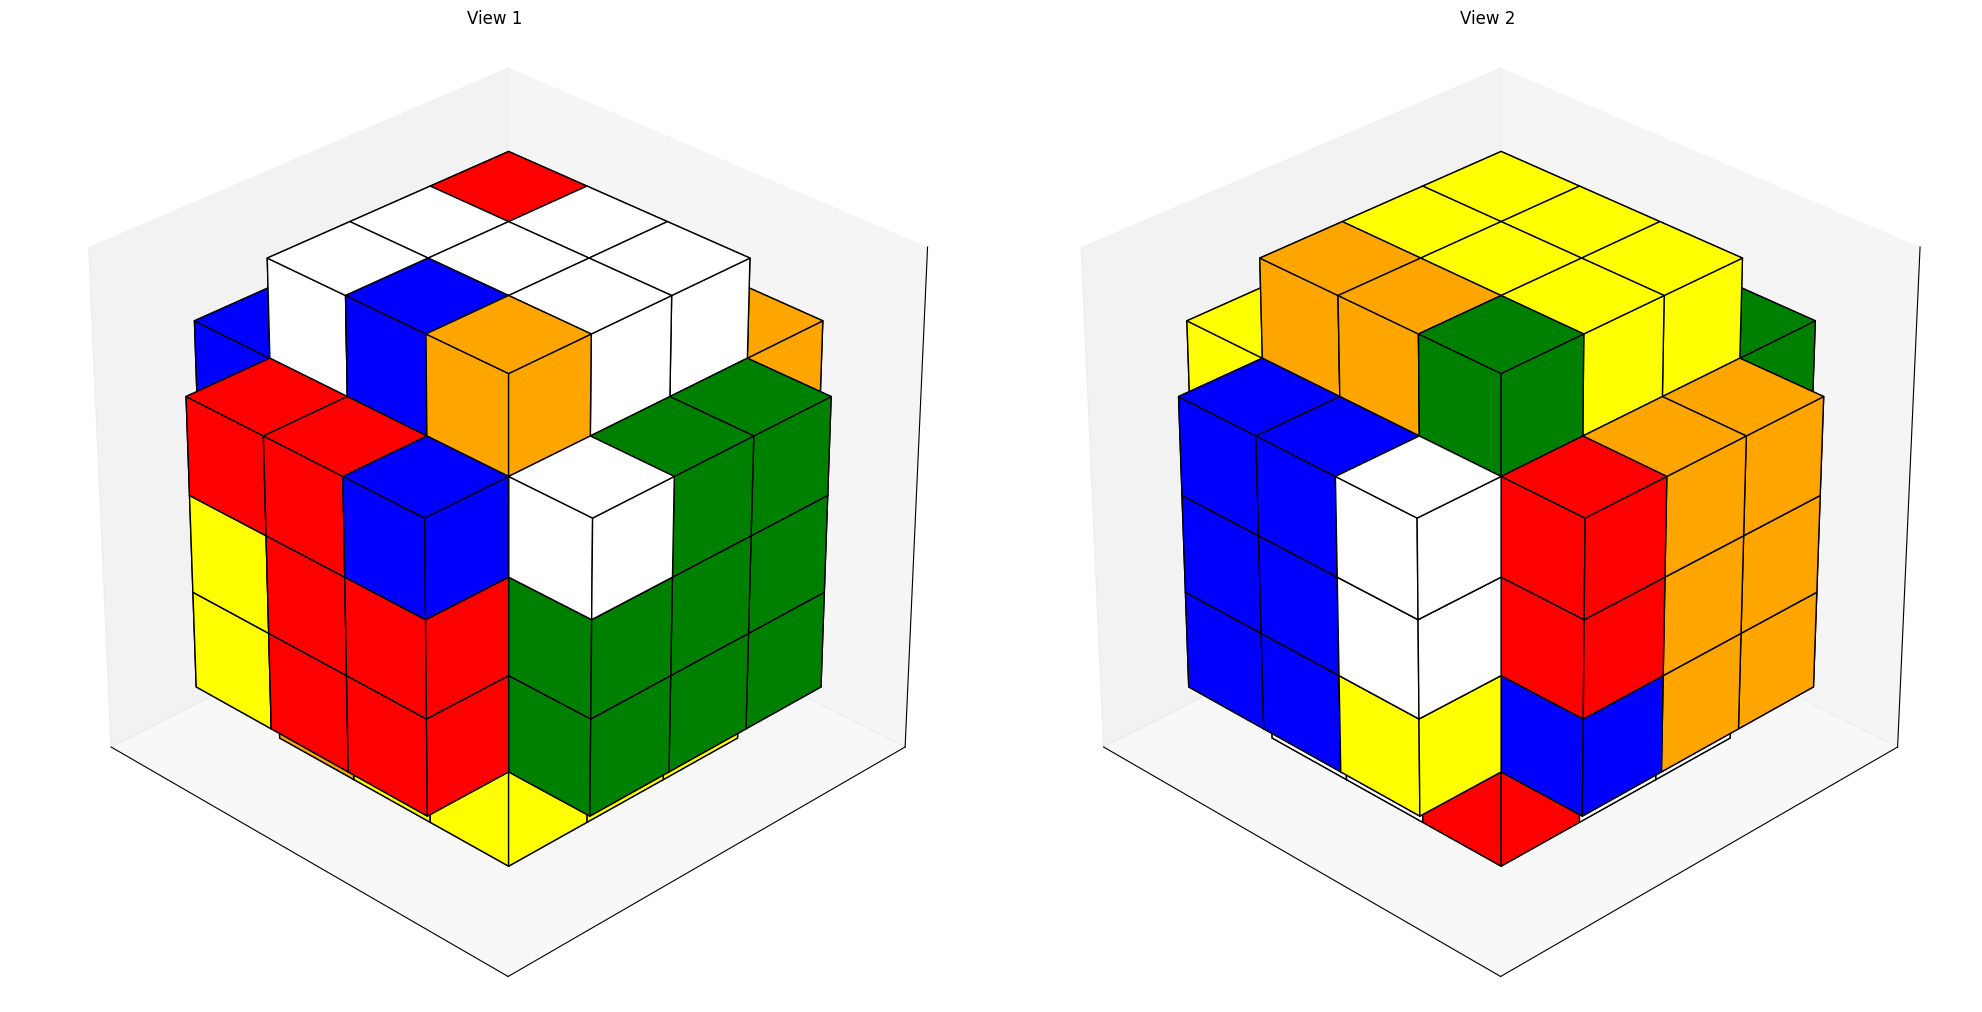

attempt 16/20
solving...


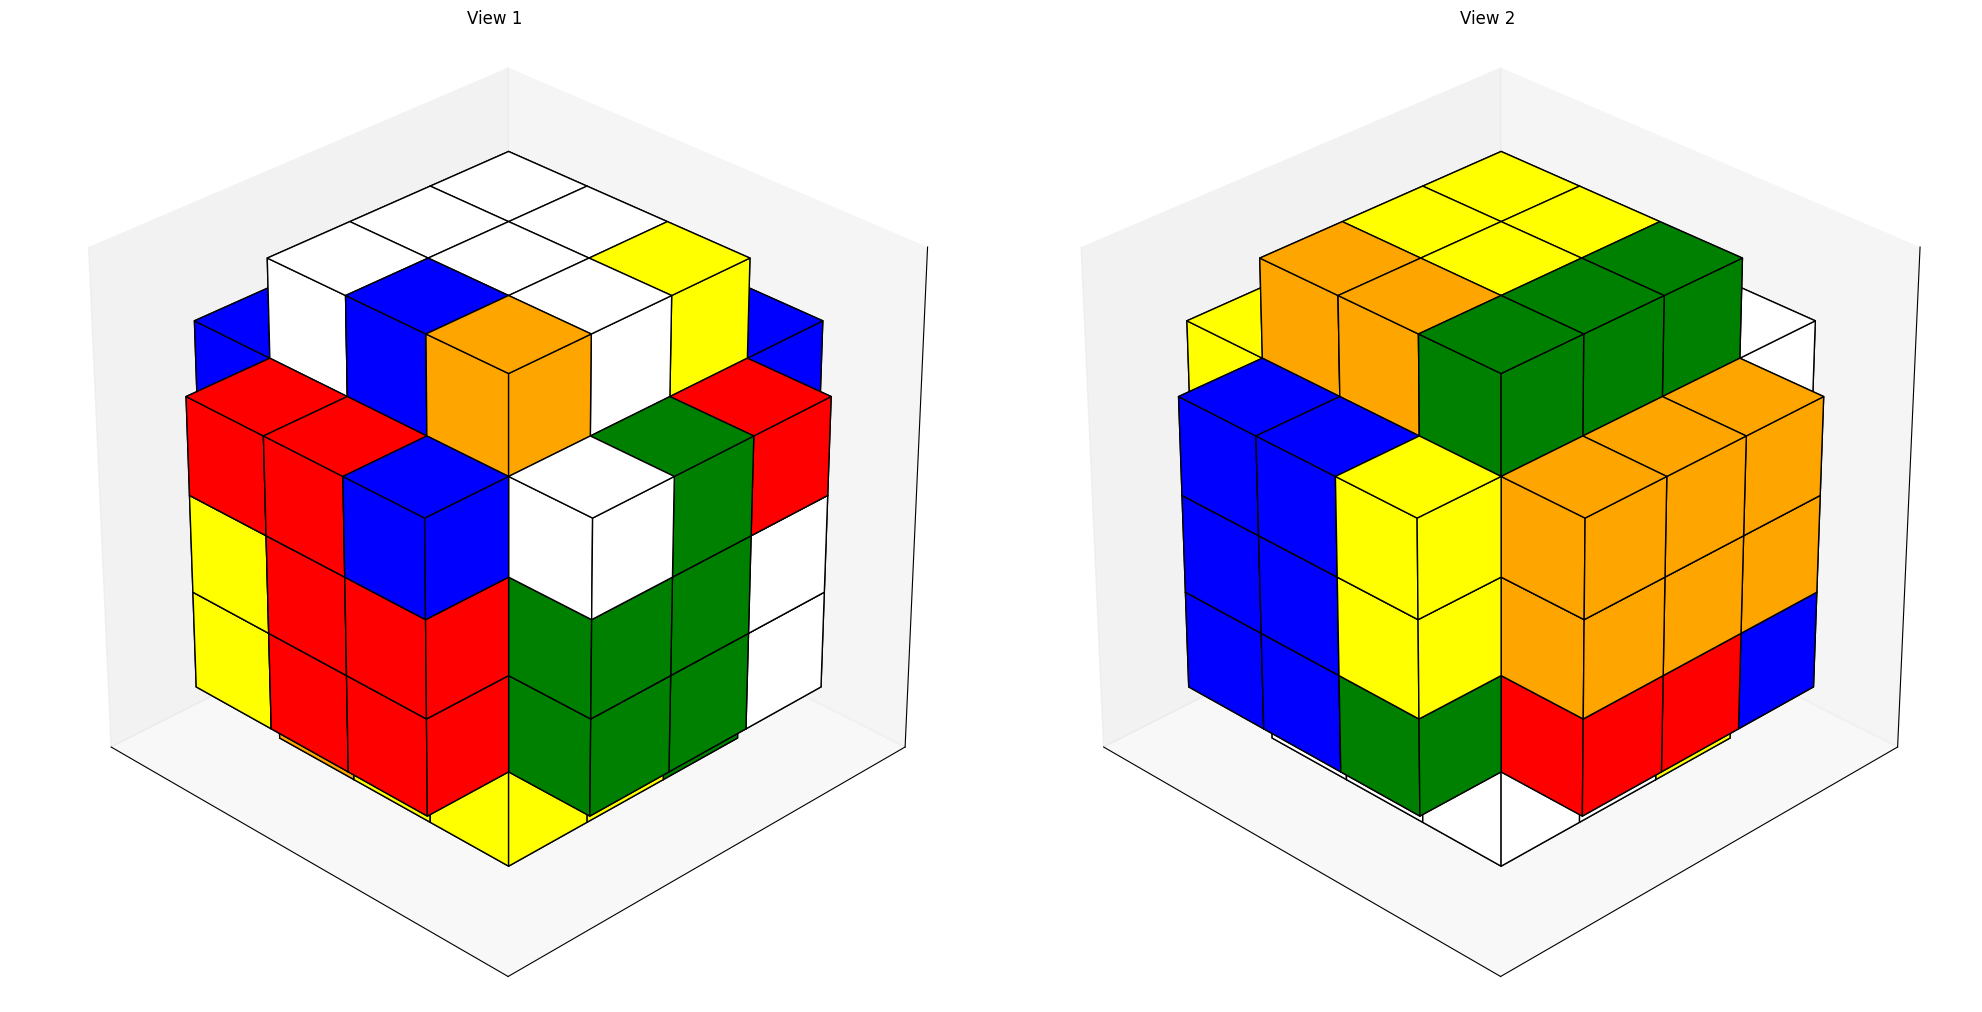

attempt 17/20
solving...


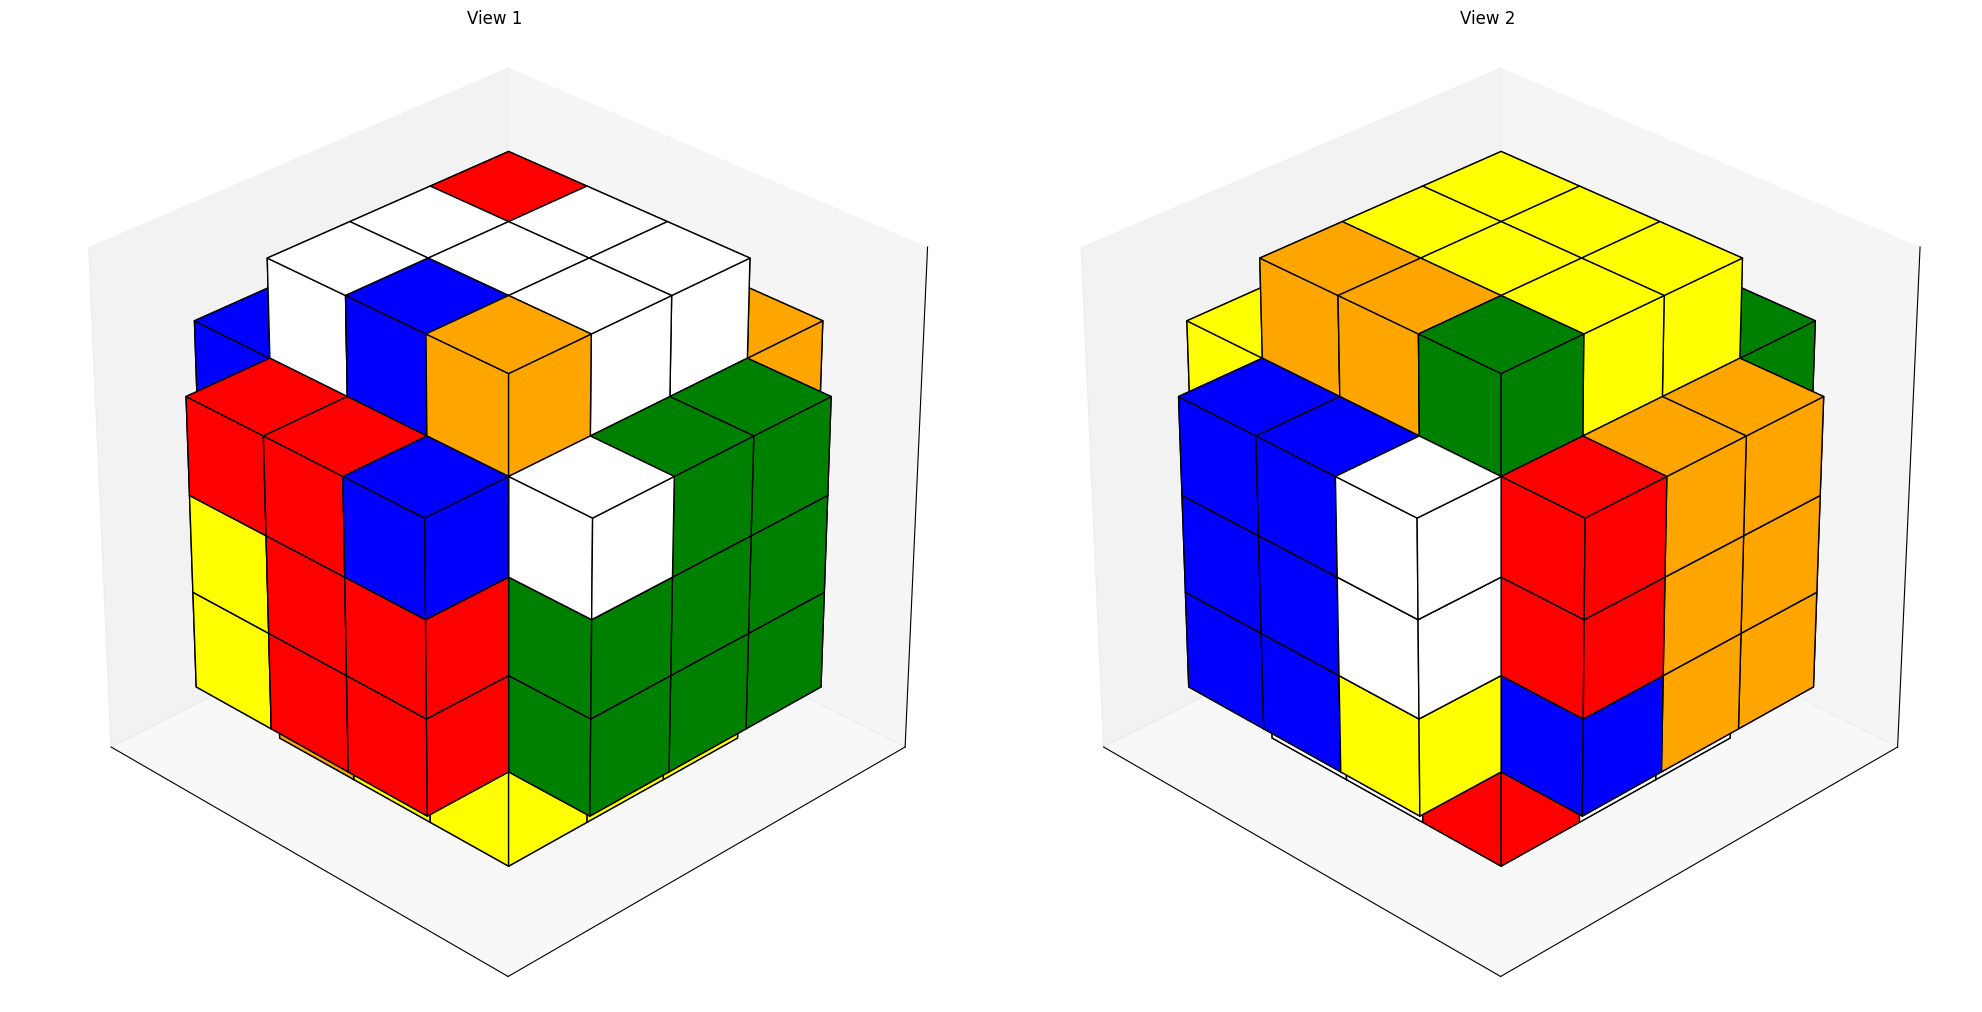

attempt 18/20
solving...


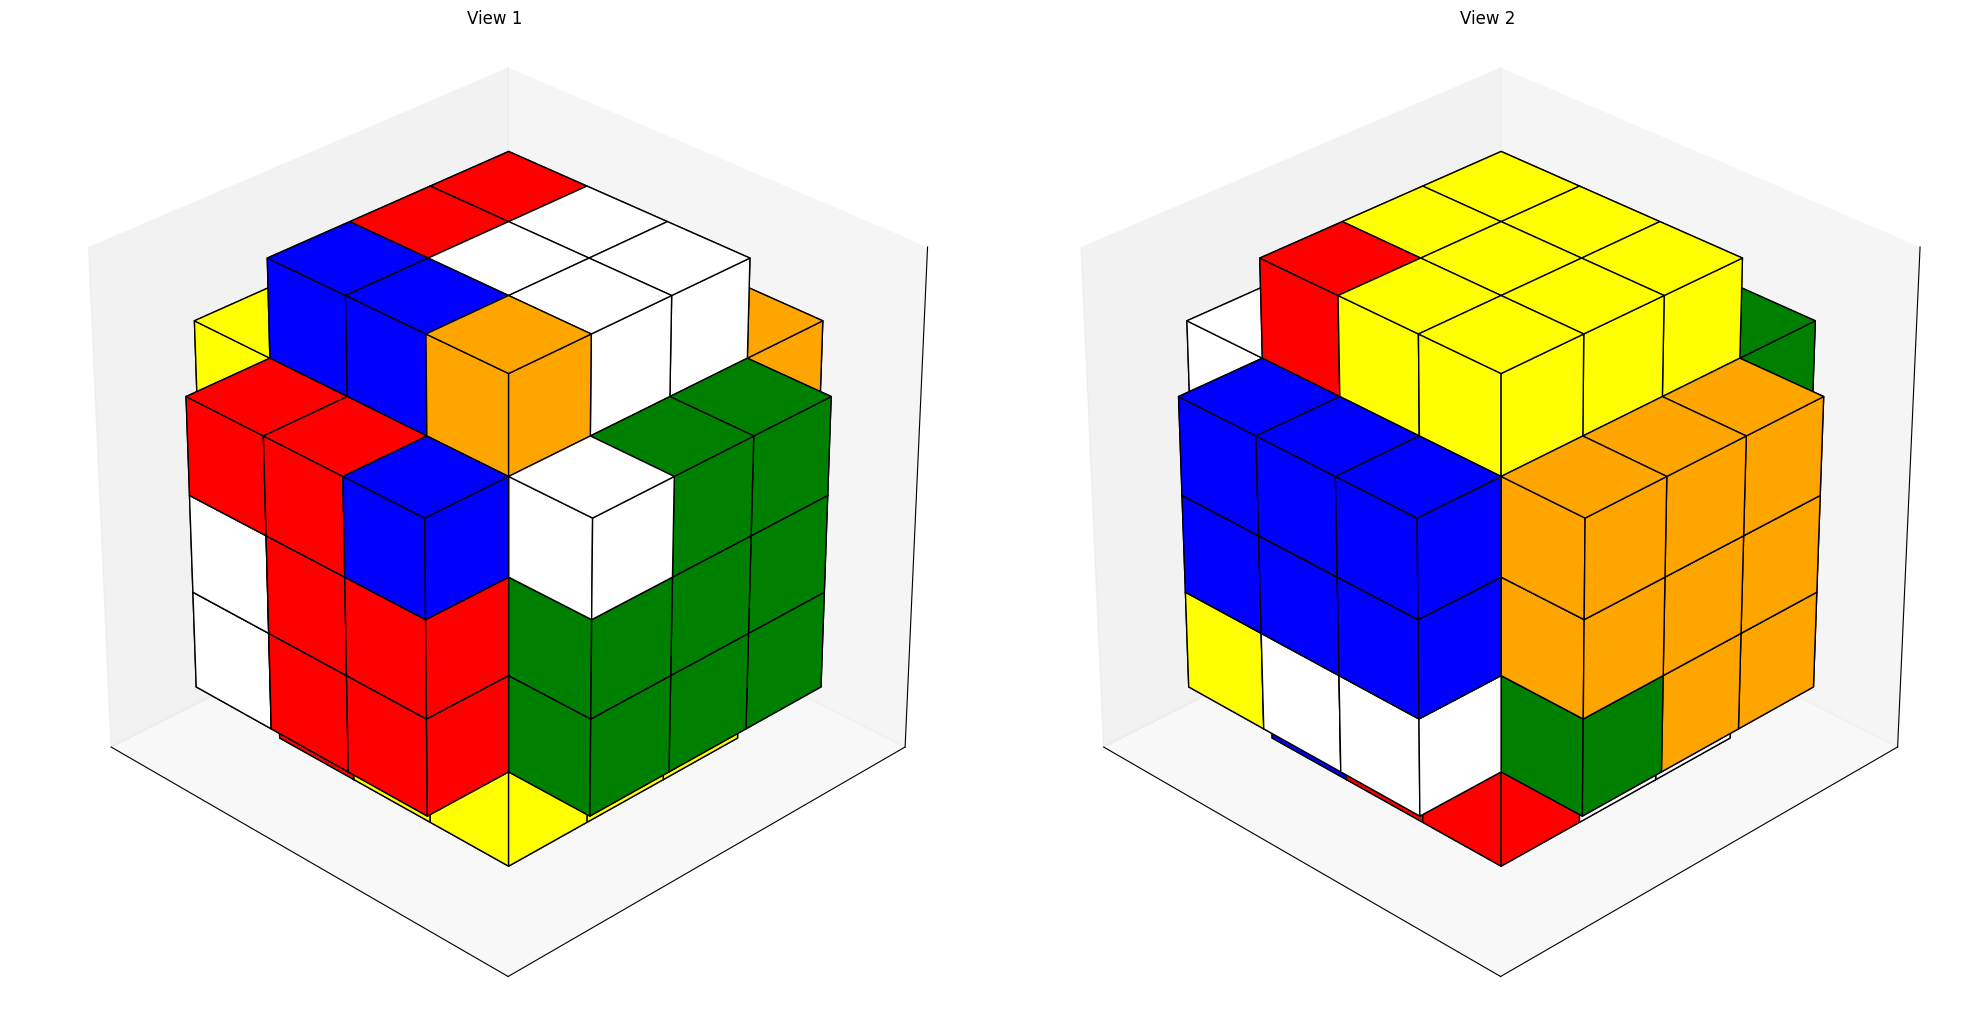

attempt 19/20
solving...


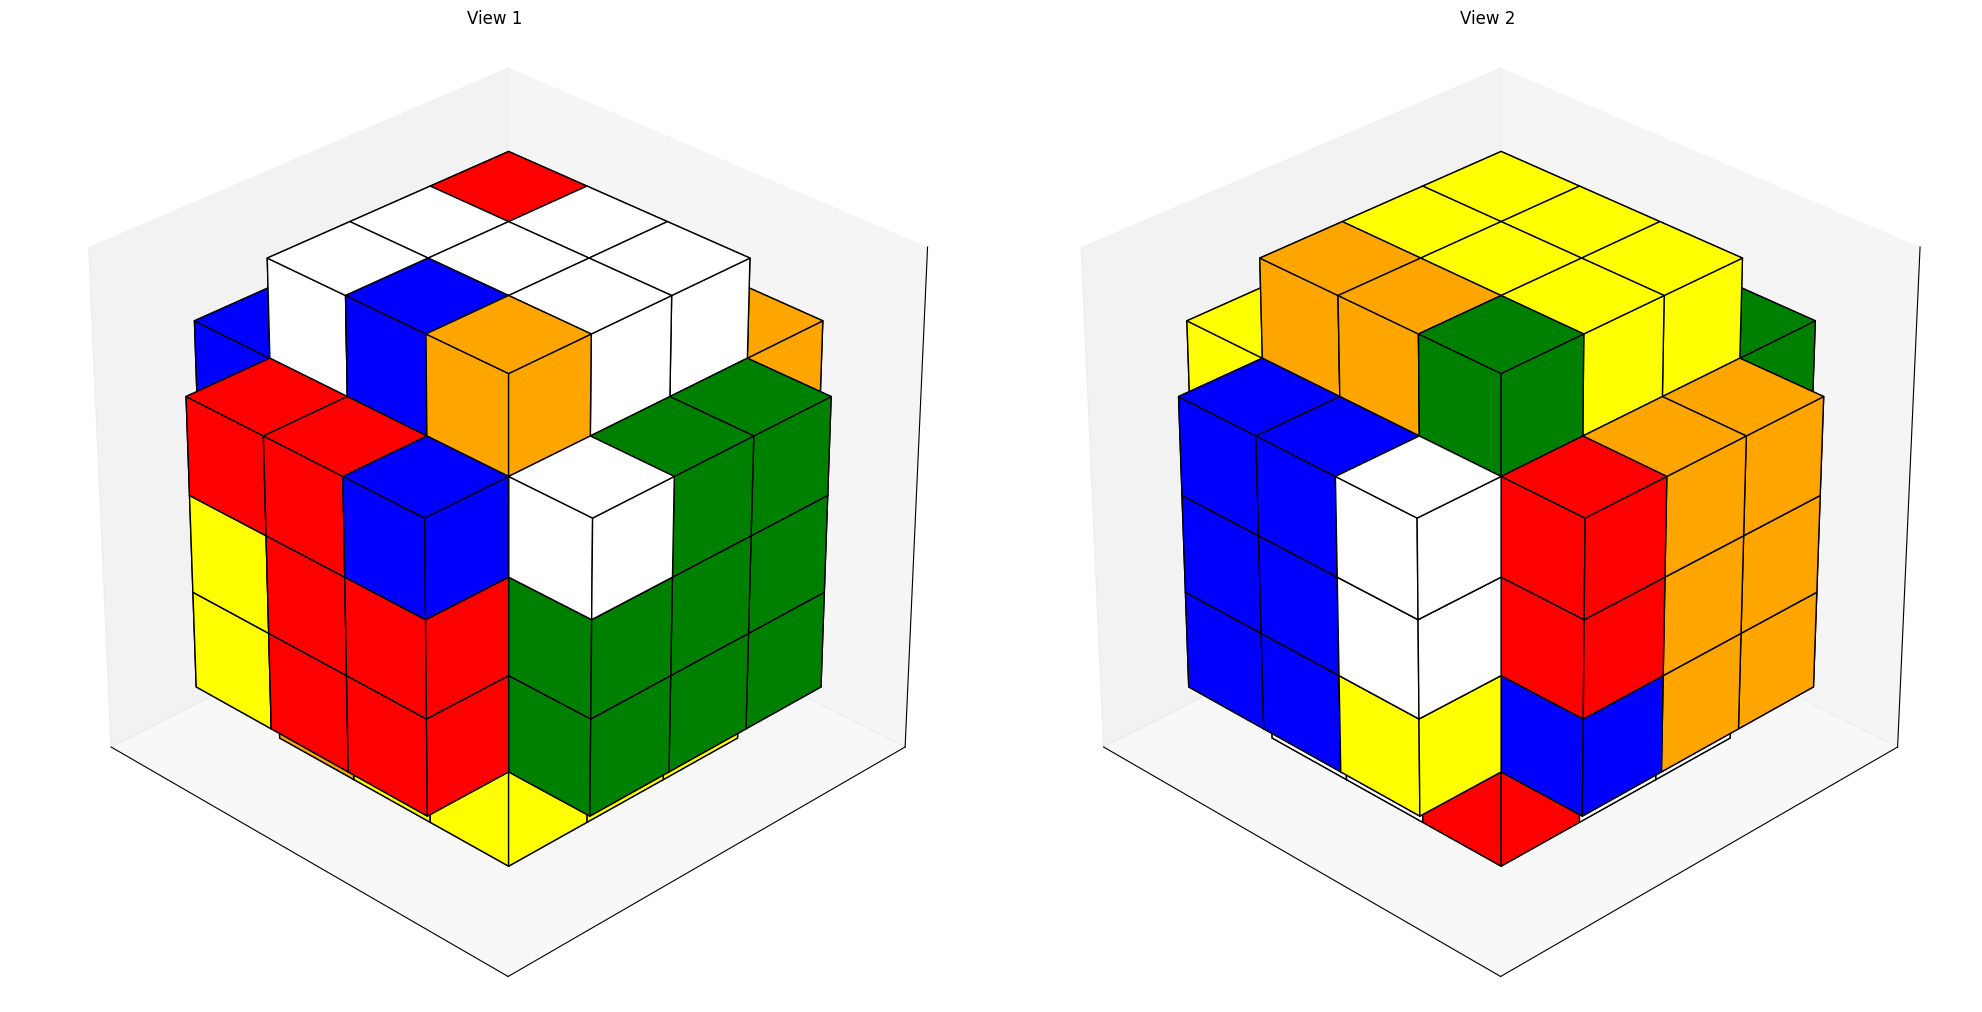

attempt 20/20
solving...


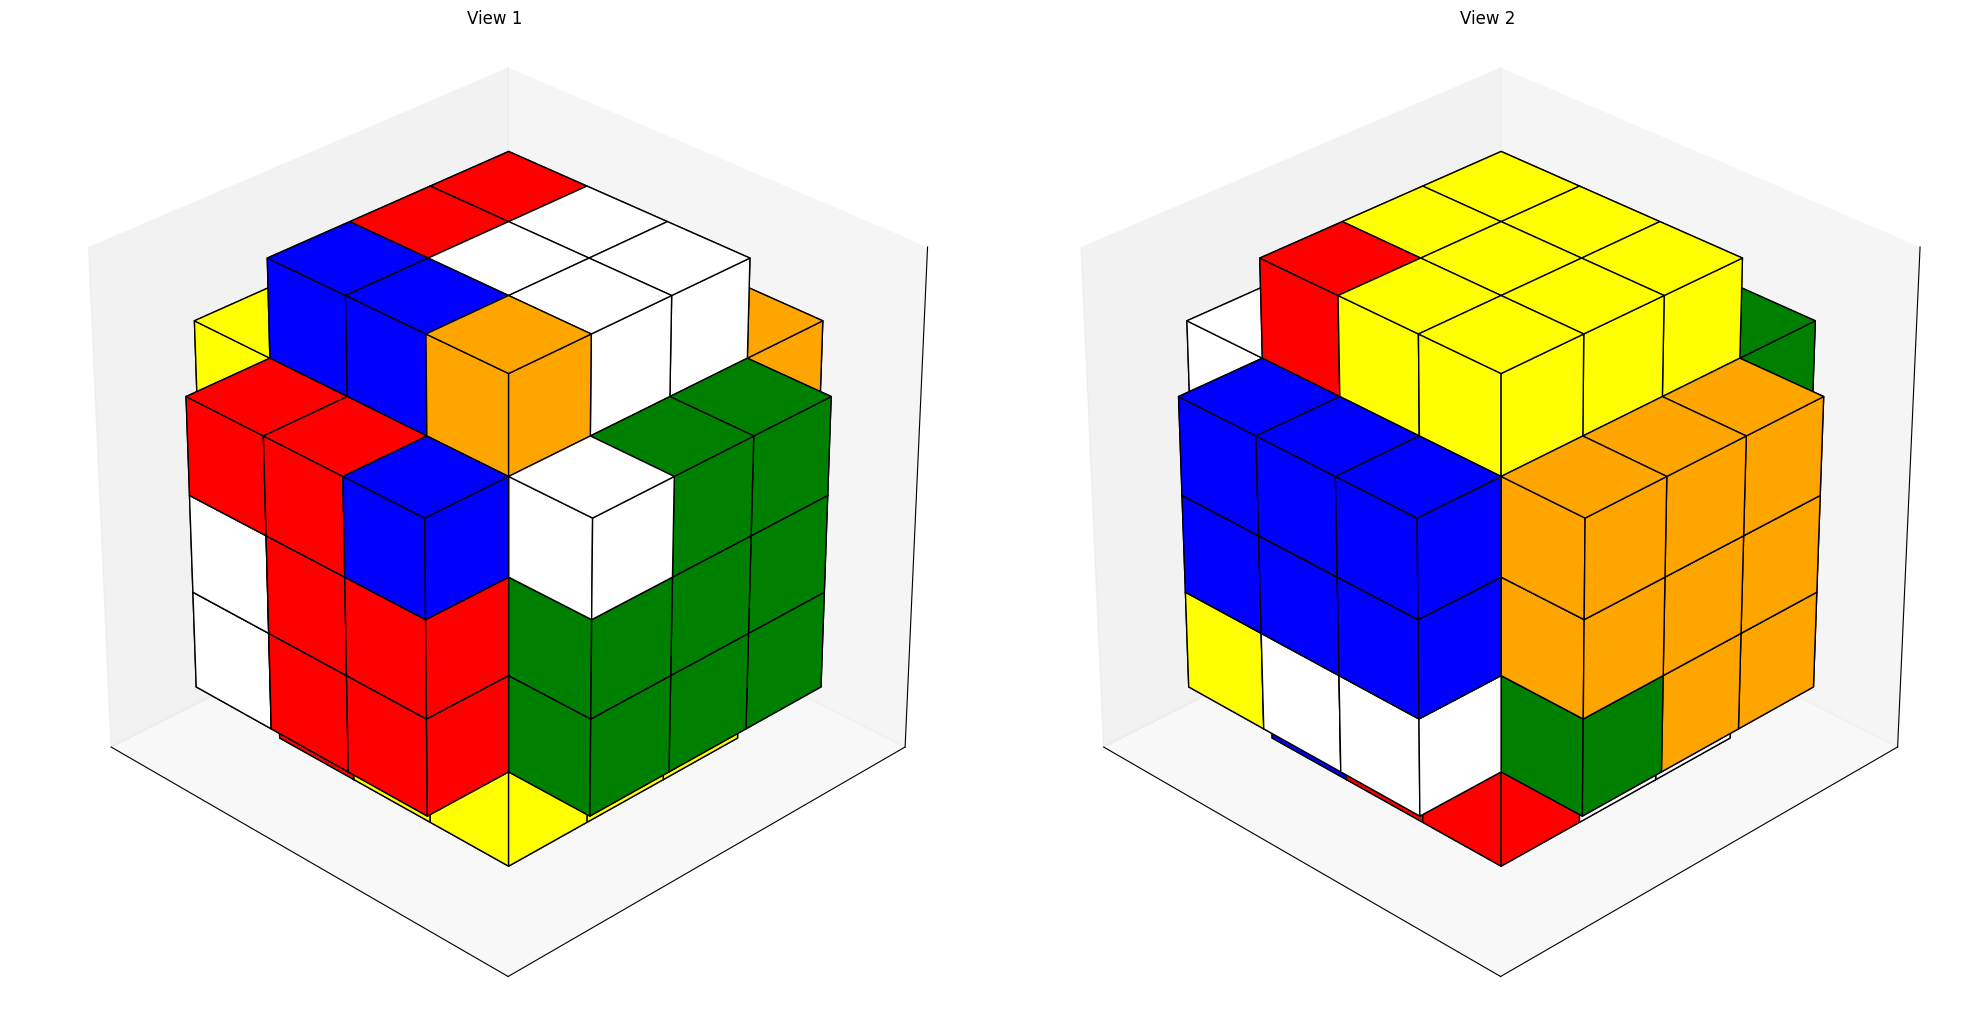

In [ ]:
max_attempts = 20

#creating a cube
cube = RubiksCube()

#shuffling
moves = scramble(cube, n=6)
print(moves)

# Visualize from opposite corners
cube.visualize_opposite_corners()

for i in range(max_attempts):

    print(f'attempt {i+1}/{max_attempts}')

    #trying to solve cube
    predict_and_execute(cube, max_iter=1)

    # Visualize from opposite corners
    cube.visualize_opposite_corners()

    if is_cube_solved(cube): break

# Note:
In iterative passes it sometimes gets stuck in a loop. Maybe choosing a probabalistic output is better than the maximum output?
I feel like for a very performant model you would always want to choose the best output, but for a semi-performant model it might make it more likely for that model to converge on a solution.

I havent tested if single pass

# Note:
I think it might actually be getting a little worse (epoch 84). I'd be curious to see how well different epochs performed on the same Rubik's Cube.

I think we're done training with this approach.